In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import make_scorer, mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, train_test_split, GroupKFold
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import eli5
import datetime
import holidays
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator

In [2]:
df = pd.read_csv("../input/energy_price.csv", parse_dates=["datetime"])
df['data'] = df['datetime'].dt.date.astype(str)

In [3]:
df.tail()

datetime   price  is_test        data
26968 2022-10-31 19:00:00  585.01    False  2022-10-31
26969 2022-10-31 20:00:00  550.96    False  2022-10-31
26970 2022-10-31 21:00:00  480.96    False  2022-10-31
26971 2022-10-31 22:00:00  430.00    False  2022-10-31
26972 2022-10-31 23:00:00  393.60    False  2022-10-31

<AxesSubplot:xlabel='datetime', ylabel='price'>

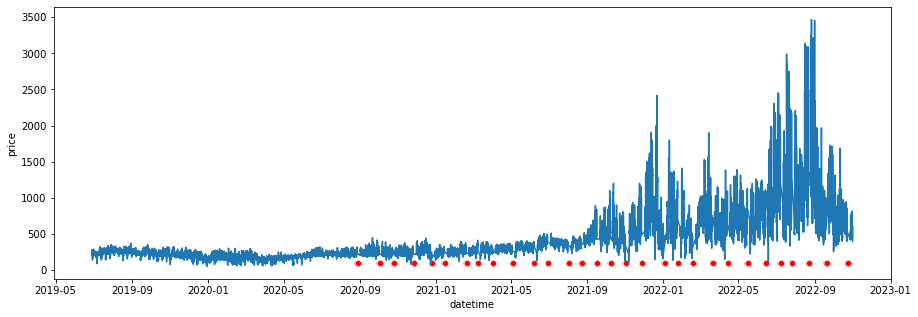

In [4]:
plt.figure(figsize=(15, 5));
sns.lineplot(x = "datetime", y = "price", data =df)
sns.scatterplot(x = "datetime", y = "price", data =df[df['price'].isnull()].fillna(100), color = "r")

In [5]:
df['price'] = np.log(df['price'])

In [6]:
df["datetime_b24h"] = df["datetime"].shift(24)
df[ df["is_test"] ].head()

datetime  price  is_test        data       datetime_b24h
10223 2020-08-27 00:00:00    NaN     True  2020-08-27 2020-08-26 00:00:00
10224 2020-08-27 01:00:00    NaN     True  2020-08-27 2020-08-26 01:00:00
10225 2020-08-27 02:00:00    NaN     True  2020-08-27 2020-08-26 02:00:00
10226 2020-08-27 03:00:00    NaN     True  2020-08-27 2020-08-26 03:00:00
10227 2020-08-27 04:00:00    NaN     True  2020-08-27 2020-08-26 04:00:00

In [7]:
is_valid_datetime_set = set(df[ df["is_test"] ]["datetime_b24h"])

df["is_valid"] = df["datetime"].map(lambda x: x in is_valid_datetime_set)
df["is_valid"].value_counts()

False    26253
True       720
Name: is_valid, dtype: int64

In [8]:
data_to_valid = df[df['is_valid']]['data'].unique()

<AxesSubplot:xlabel='datetime', ylabel='price'>

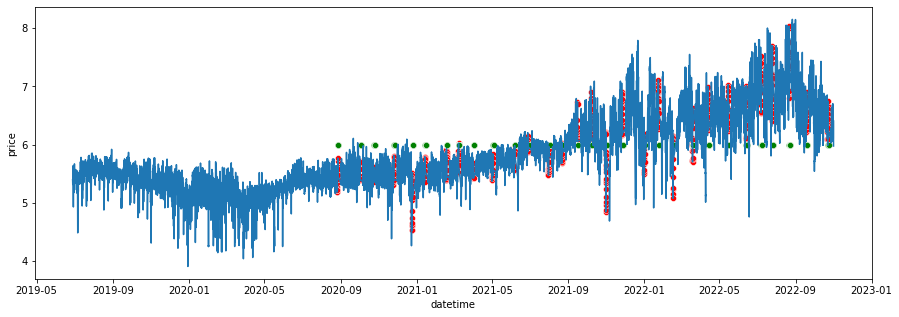

In [9]:
plt.figure(figsize=(15, 5));
sns.lineplot(x = "datetime", y = "price", data =df)
sns.scatterplot(x = "datetime", y = "price", data =df[df['is_valid']], color = "r")
sns.scatterplot(x = "datetime", y = "price", data =df[df['is_test']].fillna(6), color = "g")

# First Test shift24

In [10]:
def mape(y_test, y_pred):
    return round(np.mean( np.abs(y_test - y_pred) / y_test * 100 ),2)

In [11]:
df.head(2)

datetime     price  is_test        data datetime_b24h  is_valid
0 2019-06-28 00:00:00  5.396079    False  2019-06-28           NaT     False
1 2019-06-28 01:00:00  5.317384    False  2019-06-28           NaT     False

In [12]:
df["price_shift24"] = df["price"].shift(24)

In [13]:
mape( df[df["is_valid"]]["price"], df[df["is_valid"]]["price_shift24"])

3.14

In [14]:
# 2. Adding features

In [15]:
df["datetime_b48h"] = df["datetime"].shift(24*2)
df["datetime_b72h"] = df["datetime"].shift(24*3)
df[f"datetime_b{24*4}h"] = df["datetime"].shift(24*4)

is_train_datetime_set = set(df[ df["is_test"] ]["datetime_b48h"]) | set(df[ df["is_test"] ]["datetime_b72h"])

df["is_train"] = df["datetime"].map(lambda x: x in is_train_datetime_set)

In [16]:
df["is_train"].value_counts()

False    25533
True      1440
Name: is_train, dtype: int64

In [17]:
offset_days = 1
df[f"price_{offset_days}d"] = df["price"].shift(24*offset_days)

feats = ["price_1d"]

df_train = df[ df["is_train"] ].copy()
df_valid = df[ df["is_valid"] ].copy()

X_train = df_train[ feats ]
y_train = df_train["price"]

X_valid = df_valid[ feats ]
y_valid = df_valid["price"]

In [18]:
def plot_ts(df_valid, y_pred):
    df_valid = df_valid.reset_index(drop=True)
    df_valid["y_pred"] = y_pred
    df_valid["day"] = df_valid["datetime"].dt.date

    df_valid["mape"] = df_valid.apply(lambda x: mape(x["price"], x["y_pred"]), axis=1)
    df_valid["mape"].hist(bins=50, figsize=(15, 5))
    plt.xlabel("MAPE")
    plt.title("Rozkład błędów");
    plt.show()


    xticks = list(df_valid["day"])
    plt.figure(figsize=(15, 5))
    plt.plot(df_valid["price"], "-", label="price")
    plt.plot(df_valid["y_pred"], "-", label="predict")
    plt.xticks(rotation = 45)
    plt.legend()

    plt.xticks(range(len(xticks)), xticks, rotation=90)
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(24))
    plt.ylabel("Cena energii (w PLN)")
    plt.title("Prognozowanie cen energii")
    plt.xticks(rotation = 45)
    plt.show();



    df_valid.sort_values("day")[ ["day", "mape"] ].groupby("day").agg("mean").sort_values("day").plot(kind="bar", figsize=(15, 5))
    plt.ylabel("MAPE")
    plt.title("Błąd w prognozowaniu cen energii")
    plt.xticks(rotation = 45)
    plt.show()

In [19]:
def run_experiment(df, model, feats, flg_plot_ts=True):
    print("n feats:", len(feats))
    print(feats)

    df_train = df[ df["is_train"] ].copy().reset_index(drop=True)
    df_valid = df[ df["is_valid"] ].copy().reset_index(drop=True)
    df_test = df[ df["is_test"] ].copy().reset_index(drop=True)

    X_train = df_train[ feats ]
    y_train = df_train["price"]
    
    X_valid = df_valid[ feats ]
    y_valid = df_valid["price"]
    
    print(X_train.shape)
    model.fit(X_train[feats], y_train,
              eval_set=(X_valid[feats], y_valid),
              early_stopping_rounds=20, verbose = False)
    y_pred = model.predict(X_valid)
    
    
    
    
    df_test['pred_first'] = model.predict(df_test[feats])


    score = mape(y_valid, y_pred)
    print("MAPE: ", score)
    
    if flg_plot_ts:
        df_valid["y_pred"] = y_pred
        plot_ts(df_valid, y_pred)
    w = eli5.show_weights(model, feature_names=feats, top=len(feats))
    result = pd.read_html(w.data)[0]
    print(result.head(30))
    return _ , df_test



<AxesSubplot:xlabel='datetime', ylabel='price'>

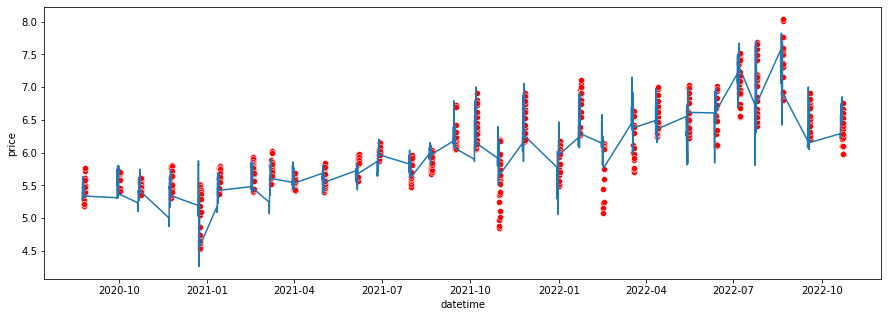

In [20]:
plt.figure(figsize=(15, 5));
sns.lineplot(x = "datetime", y = "price", data =df_train)
sns.scatterplot(x = "datetime", y = "price", data =df_valid, color = "r")

In [21]:
for offset in range(1, 30):
    df[f"price_{offset}shift"] = df["price"].shift(24*offset)

n feats: 31
['price_shift24', 'price_1d', 'price_1shift', 'price_2shift', 'price_3shift', 'price_4shift', 'price_5shift', 'price_6shift', 'price_7shift', 'price_8shift', 'price_9shift', 'price_10shift', 'price_11shift', 'price_12shift', 'price_13shift', 'price_14shift', 'price_15shift', 'price_16shift', 'price_17shift', 'price_18shift', 'price_19shift', 'price_20shift', 'price_21shift', 'price_22shift', 'price_23shift', 'price_24shift', 'price_25shift', 'price_26shift', 'price_27shift', 'price_28shift', 'price_29shift']
(1440, 31)
MAPE:  3.3


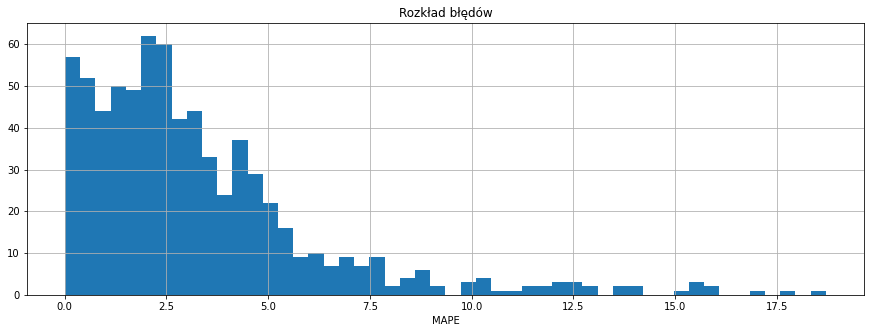

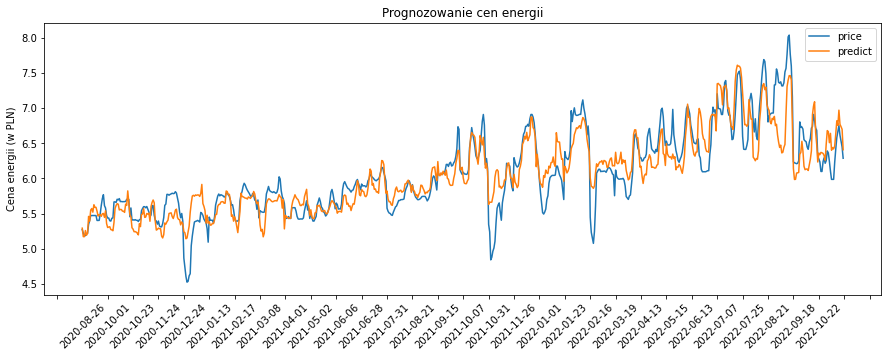

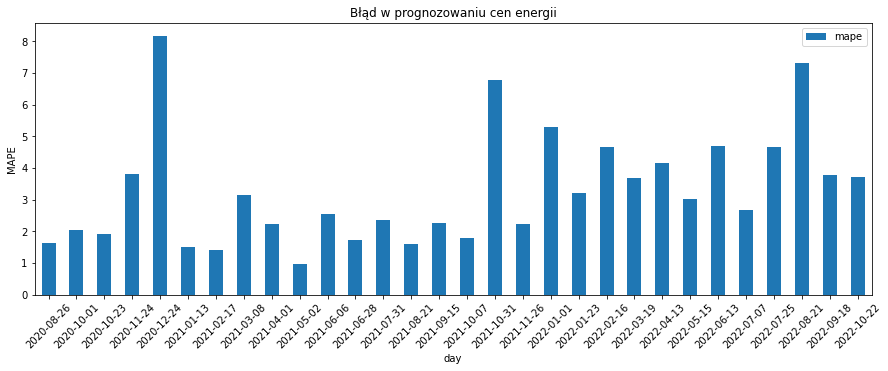

    Weight        Feature
0   0.2482   price_7shift
1   0.1284       price_1d
2   0.0724  price_24shift
3   0.0635  price_shift24
4   0.0397  price_20shift
5   0.0358  price_27shift
6   0.0336  price_11shift
7   0.0322   price_3shift
8   0.0322   price_6shift
9   0.0291  price_25shift
10  0.0284  price_10shift
11  0.0239  price_14shift
12  0.0233  price_13shift
13  0.0208  price_12shift
14  0.0182  price_19shift
15  0.0167  price_23shift
16  0.0164  price_29shift
17  0.0161   price_4shift
18  0.0159  price_16shift
19  0.0142  price_17shift
20  0.0134  price_15shift
21  0.0114  price_18shift
22  0.0110  price_21shift
23  0.0102   price_9shift
24  0.0101  price_26shift
25  0.0090   price_5shift
26  0.0077   price_2shift
27  0.0067   price_8shift
28  0.0042  price_22shift
29  0.0042  price_28shift


In [22]:
feats = [x for x in df.columns if x.startswith("price_")]

model = ctb.CatBoostRegressor(max_depth=7, n_estimators=200, learning_rate=0.3, verbose=False)
_,_ = run_experiment(df, model, feats)

In [23]:
for offset in range(1, 15):
    for agg_func in ["min","max","mean","median","std"]:
        df[f"rolling_{offset}d_price_{agg_func}"] = df["price_shift24"].rolling(24*offset).agg(agg_func)
        
for offset in range(1, 15):
    for agg_func in [0.99,0.95, 0.75, 0.25, 0.05, 0.01]:
        df[f"rolling_{offset}d_price_{agg_func}_"] = df["price_shift24"].rolling(24*offset).quantile(agg_func, interpolation='lower')

n feats: 185
['price_shift24', 'price_1d', 'price_1shift', 'price_2shift', 'price_3shift', 'price_4shift', 'price_5shift', 'price_6shift', 'price_7shift', 'price_8shift', 'price_9shift', 'price_10shift', 'price_11shift', 'price_12shift', 'price_13shift', 'price_14shift', 'price_15shift', 'price_16shift', 'price_17shift', 'price_18shift', 'price_19shift', 'price_20shift', 'price_21shift', 'price_22shift', 'price_23shift', 'price_24shift', 'price_25shift', 'price_26shift', 'price_27shift', 'price_28shift', 'price_29shift', 'rolling_1d_price_min', 'rolling_1d_price_max', 'rolling_1d_price_mean', 'rolling_1d_price_median', 'rolling_1d_price_std', 'rolling_2d_price_min', 'rolling_2d_price_max', 'rolling_2d_price_mean', 'rolling_2d_price_median', 'rolling_2d_price_std', 'rolling_3d_price_min', 'rolling_3d_price_max', 'rolling_3d_price_mean', 'rolling_3d_price_median', 'rolling_3d_price_std', 'rolling_4d_price_min', 'rolling_4d_price_max', 'rolling_4d_price_mean', 'rolling_4d_price_median', '

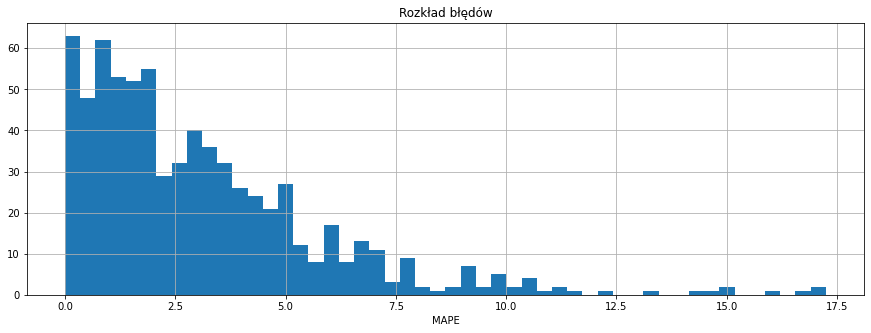

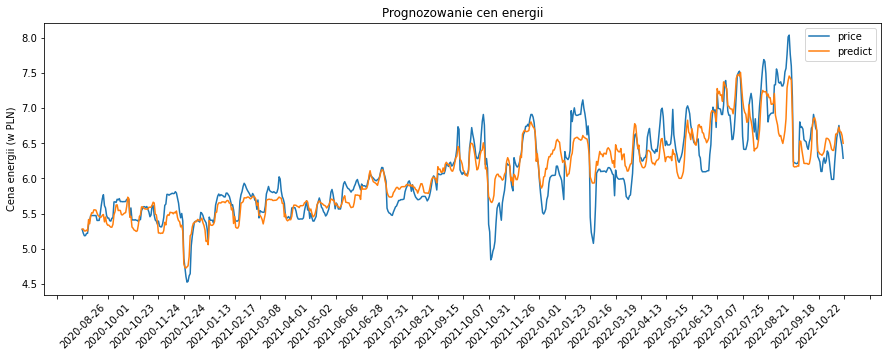

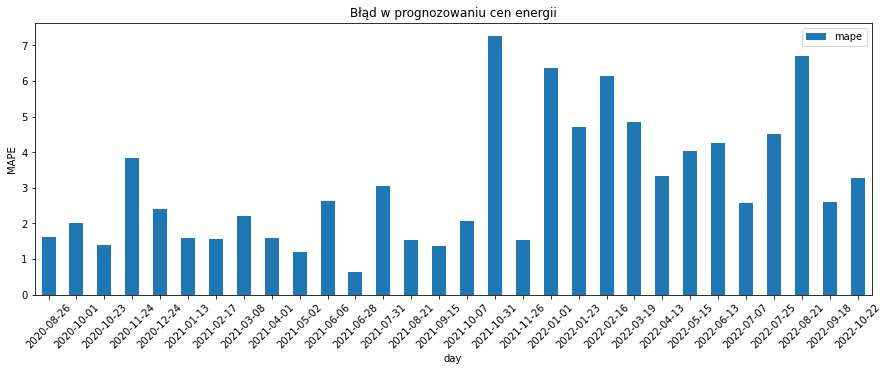

    Weight                  Feature
0   0.2120             price_7shift
1   0.0429  rolling_11d_price_0.25_
2   0.0354            price_shift24
3   0.0285     rolling_1d_price_min
4   0.0279    rolling_7d_price_mean
5   0.0266                 price_1d
6   0.0248             price_3shift
7   0.0247   rolling_6d_price_0.25_
8   0.0222            price_25shift
9   0.0203            price_10shift
10  0.0197             price_2shift
11  0.0191             price_6shift
12  0.0184             price_1shift
13  0.0182            price_11shift
14  0.0175    rolling_11d_price_std
15  0.0175             price_9shift
16  0.0167  rolling_12d_price_0.95_
17  0.0149     rolling_6d_price_std
18  0.0146            price_24shift
19  0.0132            price_29shift
20  0.0121   rolling_4d_price_0.05_
21  0.0117            price_13shift
22  0.0113    rolling_13d_price_max
23  0.0112            price_28shift
24  0.0110   rolling_7d_price_0.25_
25  0.0103     rolling_4d_price_min
26  0.0087            price_

In [24]:
feats_shifted = [x for x in df.columns if x.startswith("price_")]
feats_rolling = [x for x in df.columns if x.startswith("rolling_")]

feats = feats_shifted + feats_rolling 


model = ctb.CatBoostRegressor(max_depth=7, n_estimators=250, verbose=False)
_,_ = run_experiment(df.fillna(method = "ffill"), model, feats)

In [25]:
df['day'] = df['datetime'].dt.day
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour

df['weekday'] = df['datetime'].dt.weekday
df["dayofyear"] = df['datetime'].dt.dayofyear
df['week'] = df['datetime'].dt.week
df['is_month_start'] = df['datetime'].dt.is_month_start
df['is_month_end'] = df['datetime'].dt.is_month_end
df['is_quarter_start'] = df['datetime'].dt.is_quarter_start
df['is_quarter_end'] = df['datetime'].dt.is_quarter_end
df['dayofyear'] = df['datetime'].dt.dayofyear
df['year'] = df['datetime'].dt.year
df['quarter'] = df['datetime'].dt.quarter

df['isWeekend'] = df['weekday'].map(lambda x: 1 if (x == 5) |  (x == 6)  else 0)
df['is_year_start'] = df.apply(lambda x: 1 if (x['month'] == 1) & (x['day'] == 1) else 0, axis = 1)
df['is_year_end'] = df['datetime'].dt.is_year_end
df['taryfa_dzien'] = df['hour'].map(lambda x: 1 if ((x >=6) & (x<13)) | ((x >=15) & (x<22)) else 0 )
df['dark_hour'] = df['hour'].map(lambda x: 1 if (x >=23) & (x<=6) else 0 )

df['dark_hour_day'] = df.apply(lambda x: 1 if ((x['hour'] >= 8) & (x['hour']<=22)) and  x['weekday'] in ([0,1,2,3,4])else 0, axis=1 )

df['is_leap_year'] = df['datetime'].dt.is_leap_year
df['days_in_month'] = df['datetime'].dt.days_in_month

In [26]:
df = pd.concat([df, pd.get_dummies(df["dayofyear"], prefix='daofyear_')], axis = 1)

n feats: 567
['price_shift24', 'price_1d', 'price_1shift', 'price_2shift', 'price_3shift', 'price_4shift', 'price_5shift', 'price_6shift', 'price_7shift', 'price_8shift', 'price_9shift', 'price_10shift', 'price_11shift', 'price_12shift', 'price_13shift', 'price_14shift', 'price_15shift', 'price_16shift', 'price_17shift', 'price_18shift', 'price_19shift', 'price_20shift', 'price_21shift', 'price_22shift', 'price_23shift', 'price_24shift', 'price_25shift', 'price_26shift', 'price_27shift', 'price_28shift', 'price_29shift', 'rolling_1d_price_min', 'rolling_1d_price_max', 'rolling_1d_price_mean', 'rolling_1d_price_median', 'rolling_1d_price_std', 'rolling_2d_price_min', 'rolling_2d_price_max', 'rolling_2d_price_mean', 'rolling_2d_price_median', 'rolling_2d_price_std', 'rolling_3d_price_min', 'rolling_3d_price_max', 'rolling_3d_price_mean', 'rolling_3d_price_median', 'rolling_3d_price_std', 'rolling_4d_price_min', 'rolling_4d_price_max', 'rolling_4d_price_mean', 'rolling_4d_price_median', '

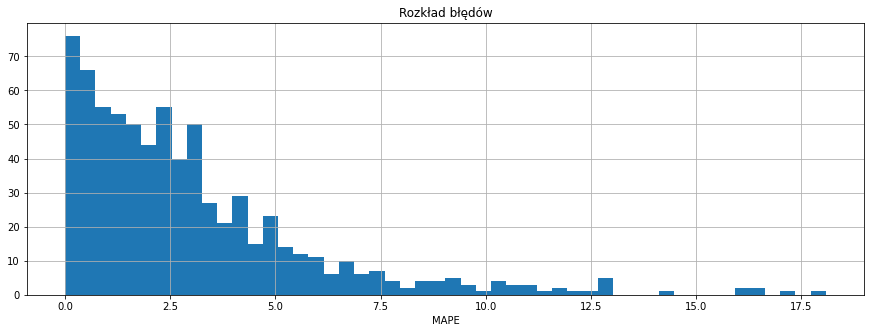

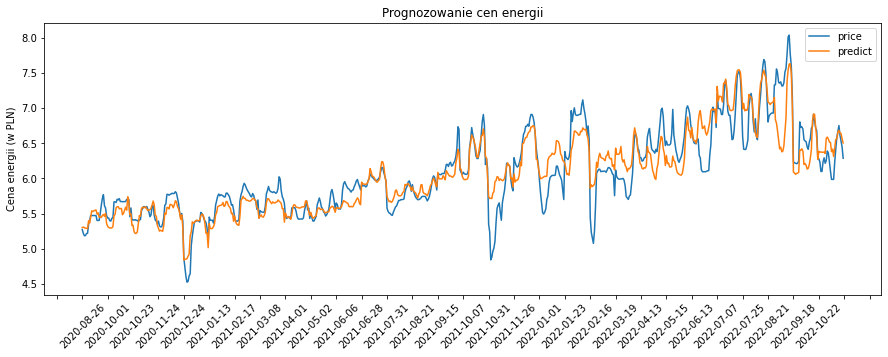

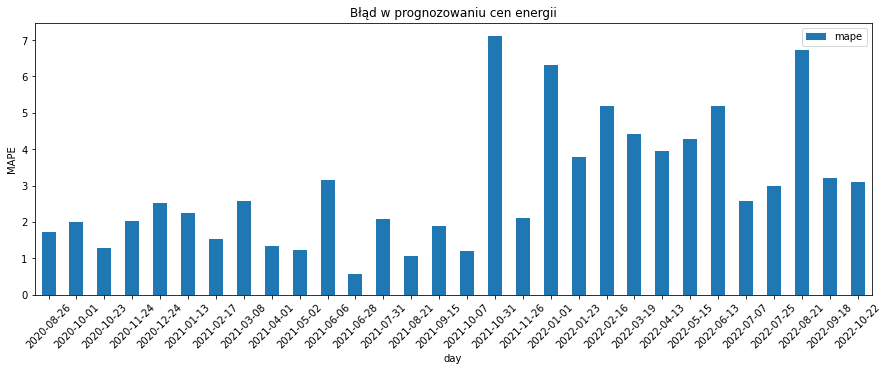

    Weight                  Feature
0   0.2312             price_7shift
1   0.0577            price_shift24
2   0.0376             price_6shift
3   0.0307     rolling_6d_price_std
4   0.0269                 price_1d
5   0.0253            price_28shift
6   0.0210             price_3shift
7   0.0195  rolling_13d_price_0.99_
8   0.0193   rolling_14d_price_mean
9   0.0190             price_1shift
10  0.0185                dayofyear
11  0.0155             price_5shift
12  0.0151            price_13shift
13  0.0150  rolling_12d_price_0.05_
14  0.0131   rolling_1d_price_0.25_
15  0.0129  rolling_11d_price_0.01_
16  0.0129            dark_hour_day
17  0.0123            price_25shift
18  0.0116            price_10shift
19  0.0112  rolling_14d_price_0.05_
20  0.0107            daofyear__358
21  0.0106    rolling_14d_price_max
22  0.0094            price_11shift
23  0.0094     rolling_7d_price_max
24  0.0092    rolling_11d_price_std
25  0.0085   rolling_10d_price_mean
26  0.0081   rolling_5d_pric

In [27]:
feats_shifted = [x for x in df.columns if x.startswith("price_")]
feats_rolling = [x for x in df.columns if x.startswith("rolling_")]

feats = feats_shifted + feats_rolling + list(df.columns[200:]) 


model = ctb.CatBoostRegressor(max_depth=7, n_estimators=250, verbose=False)
_,_ = run_experiment(df.fillna(method = "ffill").fillna(-1), model, feats)

In [28]:
for i in range(2, 15):
    for hour in range(0, 25):
        idx = df[df['hour'] == hour ].index
        df.loc[idx,f'{i}_day_avg_price'] = df[df['hour'] == hour ]['price_shift24'].rolling(i).mean()
        df.loc[idx,f'{i}_day_median_price'] = df[df['hour'] == hour ]['price_shift24'].rolling(i).median()
        df.loc[idx,f'{i}_day_min_price'] = df[df['hour'] == hour ]['price_shift24'].rolling(i).min()
        df.loc[idx,f'{i}_day_max_price'] = df[df['hour'] == hour ]['price_shift24'].rolling(i).max()

for i in range(2, 15):
    for dow in range(0, 8):
        idx = df[df['dayofweek'] == dow ].index
        df.loc[idx,f'{i}_dow_avg_price'] = df[df['dayofweek'] == dow ]['price_shift24'].rolling(i).mean()
        df.loc[idx,f'{i}_dow_median_price'] = df[df['dayofweek'] == dow ]['price_shift24'].rolling(i).median()
        df.loc[idx,f'{i}_dow_min_price'] = df[df['dayofweek'] == dow ]['price_shift24'].rolling(i).min()
        df.loc[idx,f'{i}_dow_max_price'] = df[df['dayofweek'] == dow ]['price_shift24'].rolling(i).max()

n feats: 671
['price_shift24', 'price_1d', 'price_1shift', 'price_2shift', 'price_3shift', 'price_4shift', 'price_5shift', 'price_6shift', 'price_7shift', 'price_8shift', 'price_9shift', 'price_10shift', 'price_11shift', 'price_12shift', 'price_13shift', 'price_14shift', 'price_15shift', 'price_16shift', 'price_17shift', 'price_18shift', 'price_19shift', 'price_20shift', 'price_21shift', 'price_22shift', 'price_23shift', 'price_24shift', 'price_25shift', 'price_26shift', 'price_27shift', 'price_28shift', 'price_29shift', 'rolling_1d_price_min', 'rolling_1d_price_max', 'rolling_1d_price_mean', 'rolling_1d_price_median', 'rolling_1d_price_std', 'rolling_2d_price_min', 'rolling_2d_price_max', 'rolling_2d_price_mean', 'rolling_2d_price_median', 'rolling_2d_price_std', 'rolling_3d_price_min', 'rolling_3d_price_max', 'rolling_3d_price_mean', 'rolling_3d_price_median', 'rolling_3d_price_std', 'rolling_4d_price_min', 'rolling_4d_price_max', 'rolling_4d_price_mean', 'rolling_4d_price_median', '

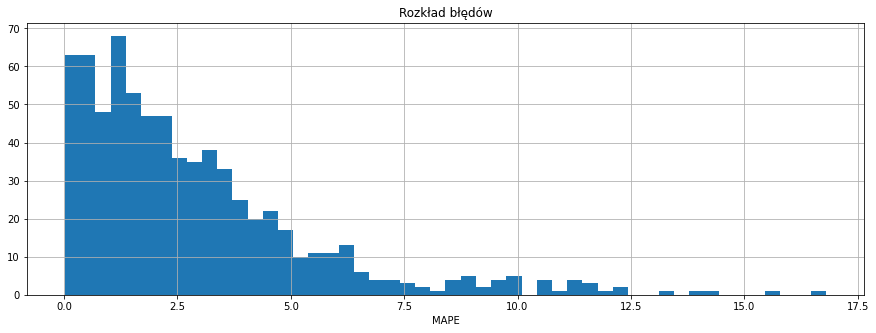

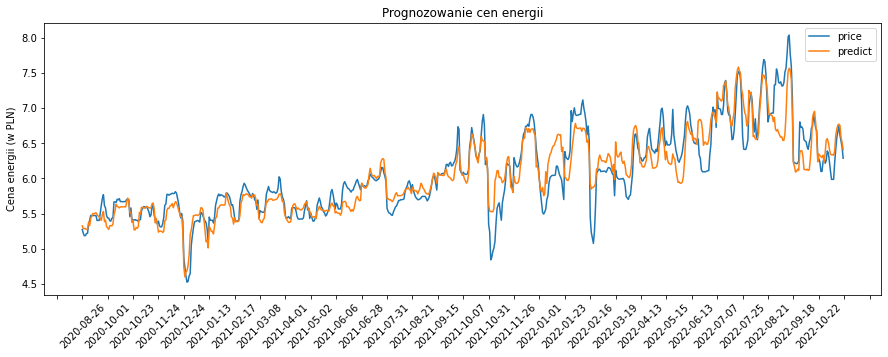

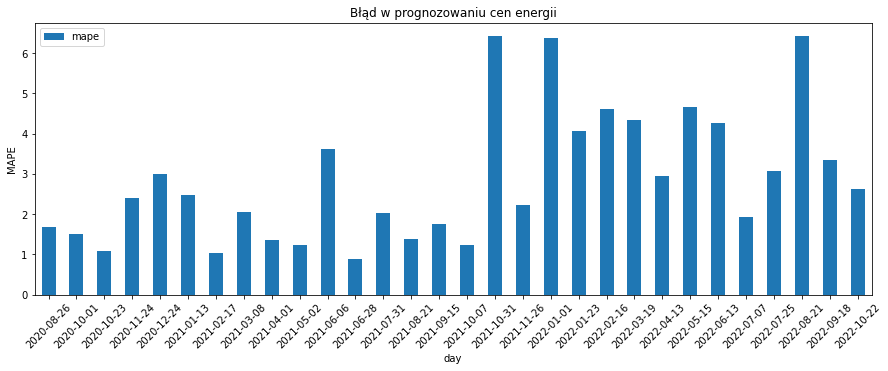

    Weight                   Feature
0   0.1529              price_7shift
1   0.0490           8_day_max_price
2   0.0392                 dayofyear
3   0.0273           4_day_max_price
4   0.0264              price_1shift
5   0.0259   rolling_11d_price_0.01_
6   0.0257       11_day_median_price
7   0.0226   rolling_3d_price_median
8   0.0220             price_25shift
9   0.0192  rolling_11d_price_median
10  0.0182              price_4shift
11  0.0145           5_day_max_price
12  0.0132             price_shift24
13  0.0120           2_day_max_price
14  0.0117             price_10shift
15  0.0117        4_day_median_price
16  0.0116      rolling_7d_price_std
17  0.0109        2_dow_median_price
18  0.0107   rolling_10d_price_0.75_
19  0.0105          11_dow_max_price
20  0.0097    rolling_7d_price_0.05_
21  0.0097    rolling_6d_price_0.75_
22  0.0089          13_dow_avg_price
23  0.0088           4_day_avg_price
24  0.0079             price_12shift
25  0.0076      rolling_5d_price_std
2

In [29]:
feats_shifted = [x for x in df.columns if x.startswith("price_")]
feats_rolling = [x for x in df.columns if x.startswith("rolling_")]

feats = feats_shifted + feats_rolling + list(df.columns[200:])

model = ctb.CatBoostRegressor(max_depth=7, n_estimators=250, verbose=False, random_state = 2)
_,df_test =  run_experiment(df.fillna(method = "ffill").fillna(-1), model, feats)

In [30]:
for i in range(15):
    df[f'_PERCENT_change{i*24}'] = ((df['price_shift24'] - df['price_shift24'].shift(24*i)) / df['price_shift24'].shift(24*i)) * 100
    
for i in range(0, 15):
    for hour in range(0, 25):
        idx = df[df['hour'] == hour ].index
        df.loc[idx,f'_PERCENT_change_HOUR{i}'] = ((df[df['hour'] == hour ]['price_shift24'] - df[df['hour'] == hour ]['price_shift24'].shift(i)) / df[df['hour'] == hour ]['price_shift24'].shift(i)) * 100
        

for i in range(2, 15):
    for dow in range(0, 8):
        idx = df[df['dayofweek'] == dow ].index
        df.loc[idx,f'_PERCENT_change_dow{i}'] = ((df[df['dayofweek'] == dow ]['price_shift24'] - df[df['dayofweek'] == dow ]['price_shift24'].shift(i)) / df[df['dayofweek'] == dow ]['price_shift24'].shift(i)) * 100
        
        
df['Kwadratowa_zmiana_ceny'] = (df['price_shift24'].diff()) ** 2
df['Wzrost_spadek_ceny'] = df['price_shift24'].diff().apply(lambda x: 1 if x > 0 else 0)

for i in range(1, 25):
    df[f'Poziom_ceny_wzgledem_maksimum_{24*i}'] = df['price_shift24'] / df['price_shift24'].rolling(24 * i).max()
    df[f'Poziom_ceny_wzgledem_min_{24*i}'] = df['price_shift24'] / df['price_shift24'].rolling(24*i).min()
    df[f'Poziom_ceny_wzgledem_mean_{24*i}'] = df['price_shift24'] / df['price_shift24'].rolling(24*i).mean()
    df[f'Poziom_ceny_wzgledem_median_{24*i}'] = df['price_shift24'] / df['price_shift24'].rolling(24*i).median()
    for agg_func in [0.99,0.95, 0.75, 0.25, 0.05, 0.01]:
        df[f'Poziom_ceny_wzgledem_quantile{agg_func}_{24*i}'] = df['price_shift24'] / df['price_shift24'].rolling(24*i).quantile(agg_func)

In [31]:
df['date_'] = df["datetime"]
df["day"] = df["date_"].dt.day
df["month"] = df["date_"].dt.month
df["hour"] = df["date_"].dt.hour
df["dayofweek"] = df['date_'].dt.dayofweek
df['dayofyear'] = df['date_'].dt.dayofyear    
df['week']= df['date_'].dt.week
df['year'] = df['date_'].dt.year
df['daynumber'] = df['date_'].map(lambda x: (x - datetime.datetime.strptime('2018-03-01', "%Y-%m-%d")).days )
df['is_holidays'] =df['date_'].dt.date.isin(holidays.CountryHoliday('PL',years=[2019,2020,2021,2022])).astype(int)

n feats: 959
['Poziom_ceny_wzgledem_quantile0.25_384', 'Poziom_ceny_wzgledem_quantile0.05_264', 'daofyear__46', 'Poziom_ceny_wzgledem_min_240', 'daofyear__137', 'daofyear__63', 'daofyear__136', 'daofyear__235', 'daofyear__351', '13_dow_avg_price', '9_dow_max_price', 'daofyear__68', '14_day_max_price', 'rolling_5d_price_0.99_', 'Poziom_ceny_wzgledem_maksimum_24', 'daofyear__292', 'Poziom_ceny_wzgledem_maksimum_288', 'daofyear__47', 'rolling_8d_price_min', 'Poziom_ceny_wzgledem_quantile0.05_528', 'daofyear__87', 'price_17shift', 'daofyear__150', 'daofyear__152', 'daofyear__263', '10_day_median_price', '4_dow_max_price', 'rolling_2d_price_0.05_', 'rolling_12d_price_0.99_', 'daofyear__278', 'daofyear__315', 'daofyear__147', 'daofyear__327', 'Poziom_ceny_wzgledem_mean_336', '4_dow_min_price', 'daofyear__176', 'daofyear__69', '9_dow_min_price', 'Poziom_ceny_wzgledem_median_312', 'quarter', 'Poziom_ceny_wzgledem_quantile0.05_288', 'daofyear__101', 'rolling_13d_price_std', 'daofyear__233', 'Po

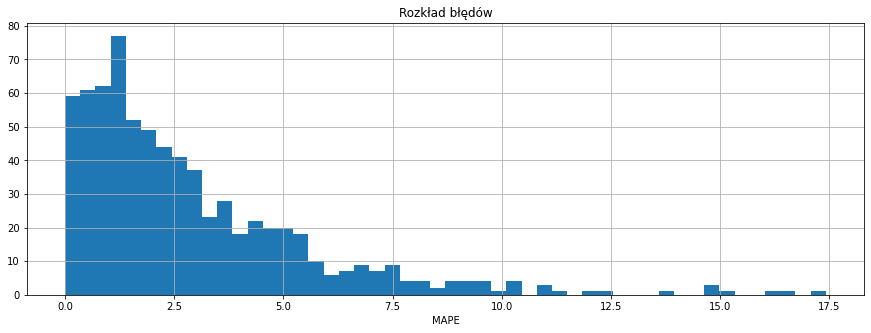

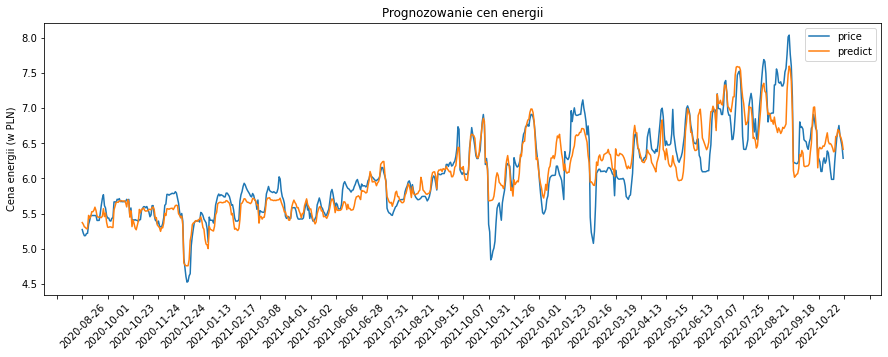

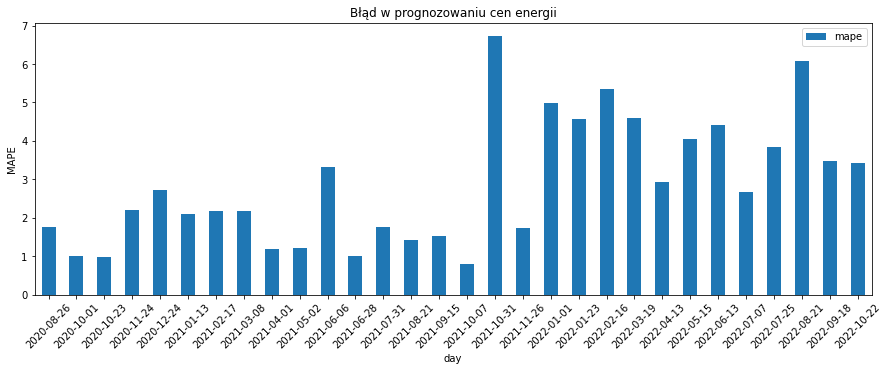

    Weight                                Feature
0   0.0726                           price_7shift
1   0.0438                rolling_14d_price_0.99_
2   0.0326                       11_day_avg_price
3   0.0277  Poziom_ceny_wzgledem_quantile0.99_552
4   0.0266                        2_day_max_price
5   0.0263                    14_dow_median_price
6   0.0247                  rolling_7d_price_mean
7   0.0242                       14_dow_avg_price
8   0.0218           Poziom_ceny_wzgledem_mean_24
9   0.0217                     5_day_median_price
10  0.0191  Poziom_ceny_wzgledem_quantile0.05_120
11  0.0179                  rolling_8d_price_mean
12  0.0179                           price_6shift
13  0.0179                        4_dow_avg_price
14  0.0177               rolling_10d_price_median
15  0.0171                              dayofyear
16  0.0168  Poziom_ceny_wzgledem_quantile0.95_384
17  0.0165      Poziom_ceny_wzgledem_maksimum_456
18  0.0165                rolling_13d_price_0.75_


In [32]:
feats_shifted = [x for x in df.columns if x.startswith("price_")]
feats_rolling = [x for x in df.columns if x.startswith("rolling_")]

feats = feats_shifted + feats_rolling + list(df.columns[200:])
feats = list(set(feats))

model = ctb.CatBoostRegressor(max_depth=5, n_estimators=250, verbose=False,
                              random_state=2
                             )
_,df_test =  run_experiment(df.fillna(method = "ffill").fillna(-1), model, feats)

In [33]:
df_train = df[ df["is_train"] ].fillna(method = "ffill").fillna(-1).copy().reset_index(drop=True)
df_valid = df[ df["is_valid"] ].fillna(method = "ffill").fillna(-1).copy().reset_index(drop=True)
df_test = df[ df["is_test"] ].fillna(method = "ffill").fillna(-1).copy().reset_index(drop=True)

X_train = df_train[ feats ]
y_train = df_train["price"]

X_valid = df_valid[ feats ]
y_valid = df_valid["price"]

In [34]:
model = ctb.CatBoostRegressor(max_depth=7, n_estimators=250, verbose=False, random_state=2)

In [35]:
# summary = model.select_features(
#     X = X_train,
#     y = y_train,
#     eval_set=(X_valid, y_valid),
#     features_for_select=f'0-{len(feats)-1}',
#     num_features_to_select=55,
#     steps=1,
#     train_final_model=True,
#     logging_level='Silent',
#     plot=True
# )

In [36]:
feat_selected = ['2_dow_median_price',
 '_PERCENT_change_dow6',
 '4_day_median_price',
 '4_day_max_price',
 'rolling_12d_price_0.75_',
 '11_dow_median_price',
 '10_day_median_price',
 'price_4shift',
 'rolling_11d_price_0.25_',
 'Poziom_ceny_wzgledem_quantile0.05_24',
 '6_day_max_price',
 'rolling_13d_price_0.25_',
 'Poziom_ceny_wzgledem_quantile0.75_240',
 'rolling_10d_price_median',
 'rolling_11d_price_0.05_',
 '12_day_avg_price',
 '_PERCENT_change_dow9',
 'rolling_3d_price_mean',
 'Poziom_ceny_wzgledem_mean_216',
 '10_day_min_price',
 '4_dow_median_price',
 'rolling_5d_price_max',
 'rolling_6d_price_min',
 'rolling_9d_price_median',
 'price_6shift',
 '3_day_avg_price',
 'rolling_13d_price_0.05_',
 'Poziom_ceny_wzgledem_quantile0.05_384',
 'rolling_4d_price_min',
 'rolling_9d_price_max',
 'Poziom_ceny_wzgledem_min_384',
 'rolling_4d_price_0.75_',
 'rolling_12d_price_std',
 'rolling_14d_price_min',
 '14_day_avg_price',
 'price_12shift',
 'price_7shift',
 'rolling_8d_price_0.05_',
 '7_day_avg_price',
 'rolling_12d_price_0.25_',
 'Poziom_ceny_wzgledem_min_96',
 '8_day_max_price',
 '3_day_max_price',
 'rolling_7d_price_0.25_',
 '5_day_avg_price',
 'rolling_2d_price_std',
 'price_shift24',
 'Poziom_ceny_wzgledem_quantile0.25_144',
 'price_17shift',
 'Poziom_ceny_wzgledem_quantile0.25_384',
 'price_26shift',
 'Poziom_ceny_wzgledem_min_120',
 '3_day_median_price',
 'rolling_12d_price_min',
 'Poziom_ceny_wzgledem_median_288']

In [37]:
# _,df_test =  run_experiment(df.fillna(method = "ffill").fillna(-1), model, summary['selected_features_names'])

In [38]:
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [39]:
# def objective(space):
    
#     cat_params = {
#         'max_depth': space['max_depth'],
#         'colsample_bylevel': space['colsample_bylevel'],
#         'learning_rate': space['learning_rate'],
#         'subsample': space['subsample'],
#       #  'random_state': 2, #int(space['seed'])
#         'reg_lambda': space['reg_lambda'],
#         'n_estimators': space['n_estimators']
#     }
    
#     print(cat_params)
#     model = ctb.CatBoostRegressor(**cat_params)
#     model.fit(X_train[summary['selected_features_names']], y_train, eval_set=(X_valid[ summary['selected_features_names']], y_valid), early_stopping_rounds=20, verbose = False)
    
#     y_pred = model.predict(X_valid[summary['selected_features_names']])

#     score =   mape(y_valid, y_pred)
#     print(f"__SCORE___: {score}")
#     return{'loss':score, 'status': STATUS_OK }
    
# space ={
#     'max_depth': hp.quniform ('max_depth', 3, 12, 1),
#     'n_estimators': hp.quniform ('n_estimators', 50, 1000, 50),
#     'colsample_bylevel': hp.uniform ('colsample_bylevel', 0.2, 1.),
#     'learning_rate': hp.uniform ('learning_rate', 0.05, 0.4),
#     'subsample': hp.uniform ('subsample', 0.6, 1.),
#     'reg_lambda': hp.uniform ('reg_lambda', 0.7, 1.)
# }


# trials = Trials()
# best_params = fmin(fn=objective,
#             space=space,
#             algo=partial(tpe.suggest, n_startup_jobs=1),
#             max_evals=300,
#             trials=trials)

# print("The best params: ", best_params)

In [40]:
params = {'colsample_bylevel': 0.925116917042069,
          'learning_rate': 0.18703415110296998, 
          'max_depth': 9.0,
          'n_estimators': 50.0,
          'reg_lambda': 0.8246795927939435,
          'subsample': 0.7734695228430521}

In [42]:
model = ctb.CatBoostRegressor(**params, random_state=2)
model.fit(X_train[feat_selected], y_train,
          eval_set=(X_valid[ feat_selected], y_valid))

y_pred = model.predict(X_valid[feat_selected])
X_valid['pred_first'] = y_pred
score =   mape(y_valid, y_pred)
print(score)

0:	learn: 0.4851603	test: 0.5131664	best: 0.5131664 (0)	total: 56.7ms	remaining: 2.78s
1:	learn: 0.4167168	test: 0.4518599	best: 0.4518599 (1)	total: 115ms	remaining: 2.75s
2:	learn: 0.3583026	test: 0.4007091	best: 0.4007091 (2)	total: 157ms	remaining: 2.46s
3:	learn: 0.3118064	test: 0.3626776	best: 0.3626776 (3)	total: 210ms	remaining: 2.41s
4:	learn: 0.2745259	test: 0.3377283	best: 0.3377283 (4)	total: 247ms	remaining: 2.22s
5:	learn: 0.2480651	test: 0.3152690	best: 0.3152690 (5)	total: 282ms	remaining: 2.07s
6:	learn: 0.2251112	test: 0.3002922	best: 0.3002922 (6)	total: 318ms	remaining: 1.95s
7:	learn: 0.2029753	test: 0.2907488	best: 0.2907488 (7)	total: 352ms	remaining: 1.85s
8:	learn: 0.1855652	test: 0.2835305	best: 0.2835305 (8)	total: 396ms	remaining: 1.8s
9:	learn: 0.1708531	test: 0.2746490	best: 0.2746490 (9)	total: 427ms	remaining: 1.71s
10:	learn: 0.1574913	test: 0.2670025	best: 0.2670025 (10)	total: 456ms	remaining: 1.62s
11:	learn: 0.1478166	test: 0.2625755	best: 0.2625755

<ipython-input-42-d872a96b52de>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['pred_first'] = y_pred


In [43]:
df_train = df[ df["is_train"] | df["is_valid"] ].sort_values("datetime").fillna(method = "ffill").fillna(-1).copy().reset_index(drop=True)
df_test = df[ df["is_test"] ].fillna(method = "ffill").fillna(-1).copy().reset_index(drop=True)

X_train = df_train[ feats ]
y_train = df_train["price"]

In [44]:
df_train.shape

(2160, 974)

In [45]:
model = ctb.CatBoostRegressor(**params, random_state=2)
model.fit(X_train[feat_selected], y_train)

### predykcja na test
df_test['pred_first'] = model.predict(df_test[feats])

0:	learn: 0.4917385	total: 40.3ms	remaining: 1.97s
1:	learn: 0.4246366	total: 69ms	remaining: 1.66s
2:	learn: 0.3681783	total: 97.1ms	remaining: 1.52s
3:	learn: 0.3233878	total: 124ms	remaining: 1.43s
4:	learn: 0.2871239	total: 161ms	remaining: 1.45s
5:	learn: 0.2609711	total: 191ms	remaining: 1.4s
6:	learn: 0.2345685	total: 239ms	remaining: 1.47s
7:	learn: 0.2147470	total: 270ms	remaining: 1.42s
8:	learn: 0.1997150	total: 304ms	remaining: 1.39s
9:	learn: 0.1875638	total: 350ms	remaining: 1.4s
10:	learn: 0.1764850	total: 382ms	remaining: 1.35s
11:	learn: 0.1697849	total: 415ms	remaining: 1.31s
12:	learn: 0.1618459	total: 461ms	remaining: 1.31s
13:	learn: 0.1558979	total: 492ms	remaining: 1.27s
14:	learn: 0.1494927	total: 540ms	remaining: 1.26s
15:	learn: 0.1446462	total: 576ms	remaining: 1.22s
16:	learn: 0.1399415	total: 609ms	remaining: 1.18s
17:	learn: 0.1364278	total: 661ms	remaining: 1.17s
18:	learn: 0.1339068	total: 691ms	remaining: 1.13s
19:	learn: 0.1305680	total: 739ms	remainin

# Second model

In [46]:
train = df[df['is_test'] == False]
train = train[train['is_valid'] == False]

print(train.shape)
model = ctb.CatBoostRegressor(max_depth=5, n_estimators=250, verbose=False, random_state = 2)
model.fit(train[feats], train['price'])

y_pred = model.predict(X_valid[feats])
X_valid['pred_second'] = y_pred

(25533, 974)


<ipython-input-46-a80eb4dc86bf>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid['pred_second'] = y_pred


In [47]:
mape(y_valid, y_pred)

3.19

In [48]:
valid = df[df['is_valid'] == True].reset_index()
valid[['pred_first','pred_second']] = X_valid[['pred_first','pred_second']]

In [49]:
train = df[df['is_test'] == False]
print(train.shape)
model = ctb.CatBoostRegressor(max_depth=5, n_estimators=250, verbose=False, random_state = 2)
model.fit(train[feats], train['price'])

(26253, 974)


In [50]:
df_test['pred_second_all_data'] = model.predict(df_test[feats])

In [51]:
date_to_pred = df[df['is_valid']]['data'].drop_duplicates().tolist()

# Third model

In [52]:
features = [f for f in feats if f != "date_"]

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


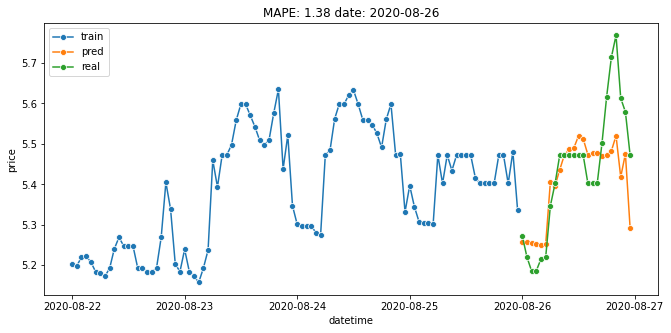

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


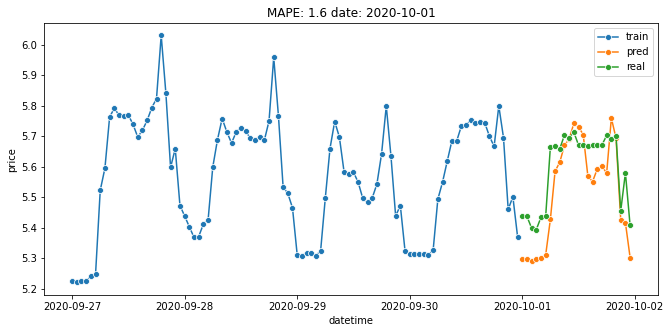

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


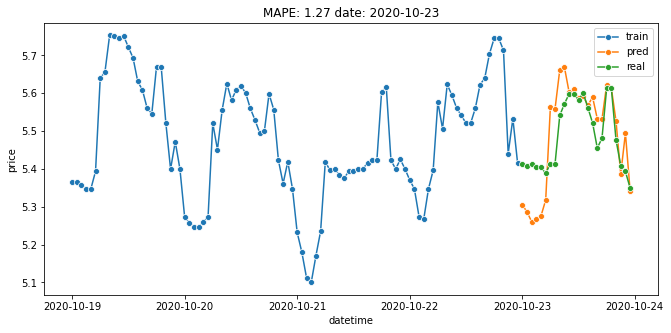

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


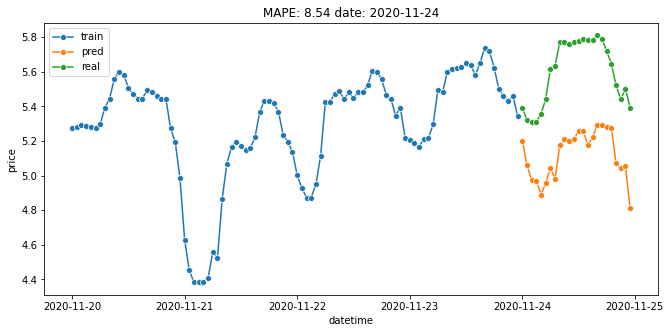

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


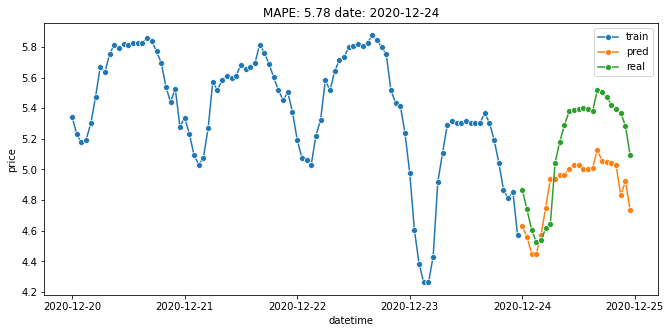

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


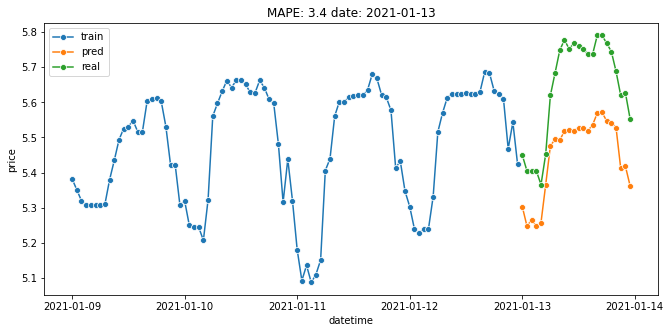

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


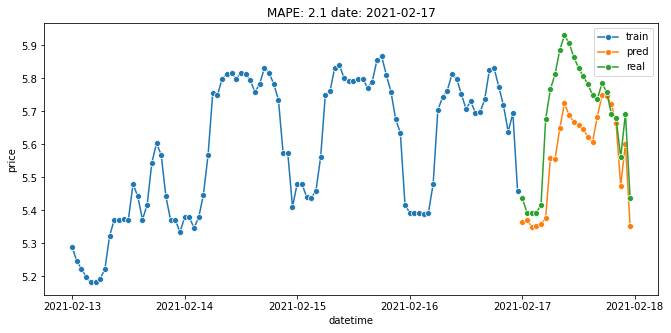

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


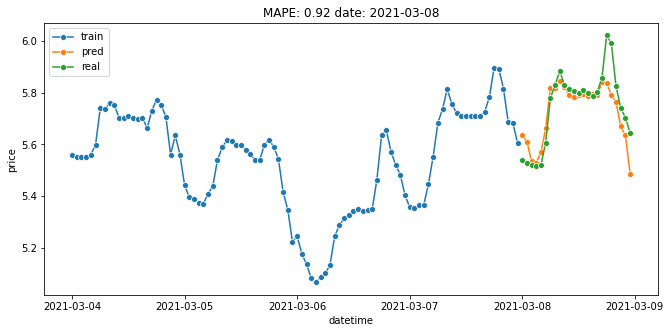

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


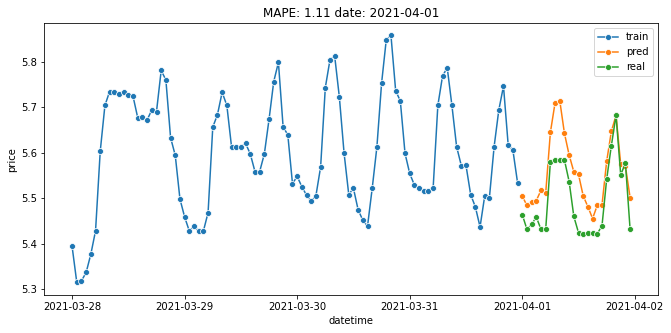

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


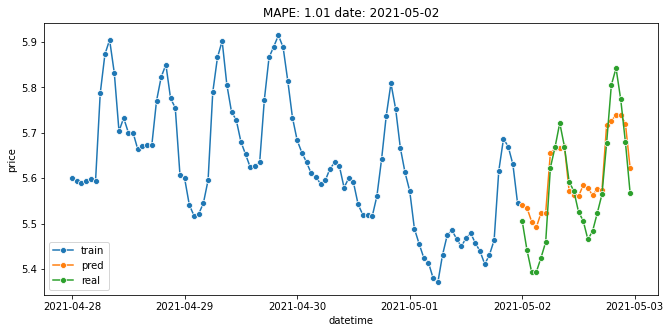

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


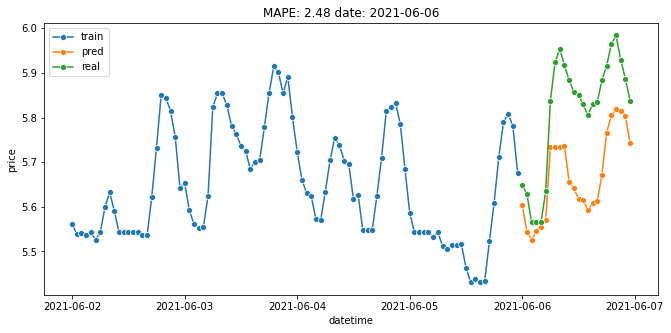

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


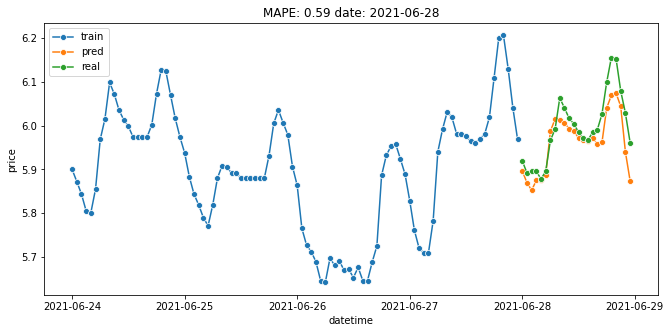

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


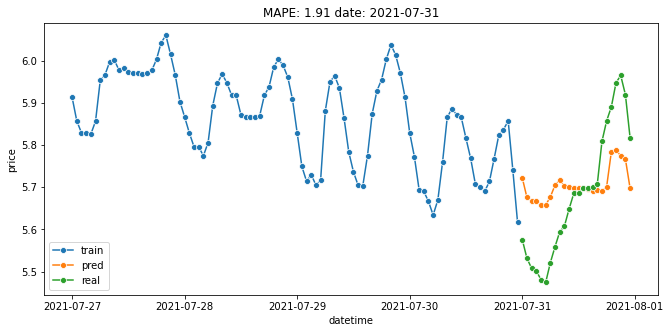

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


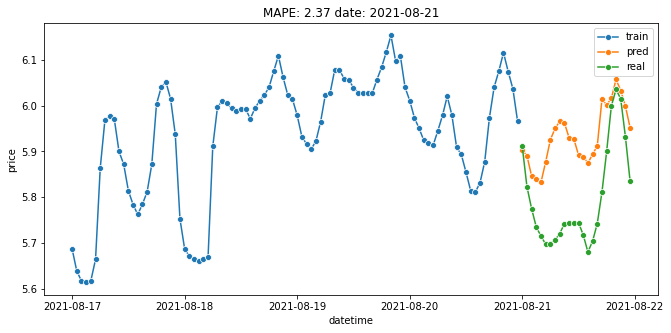

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


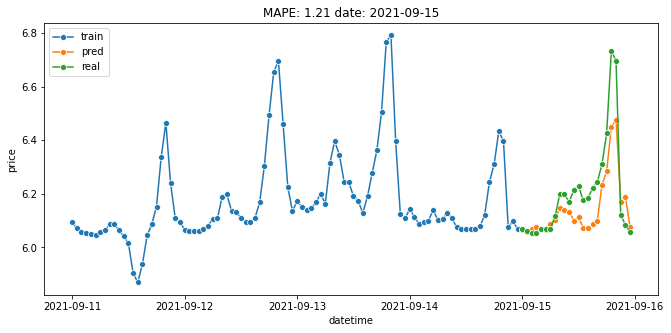

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


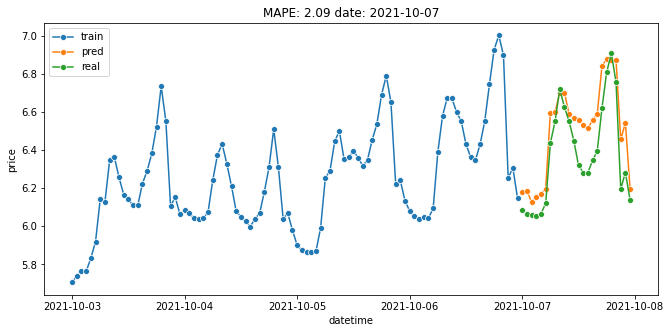

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


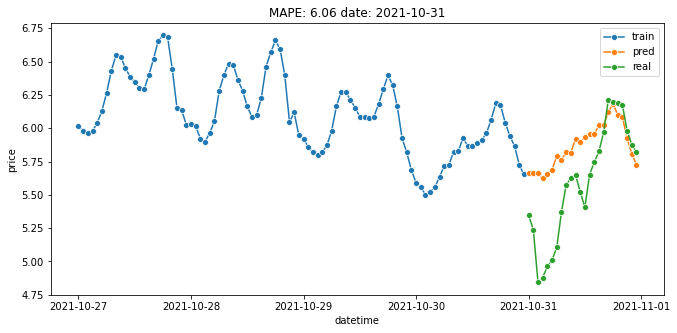

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


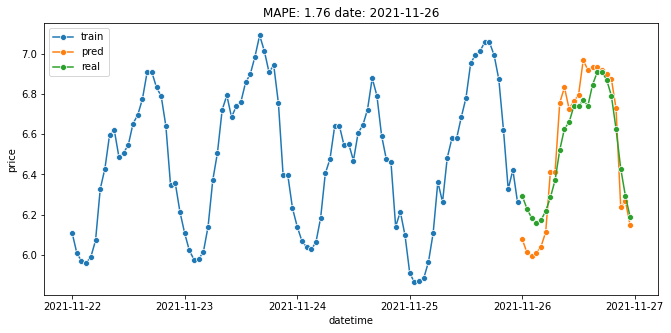

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


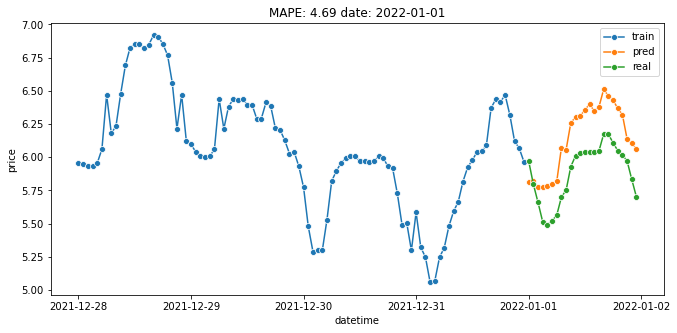

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


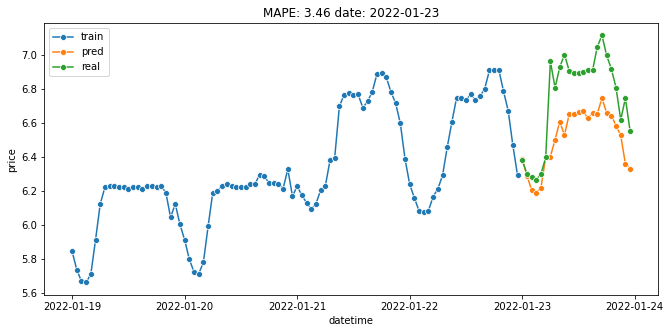

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


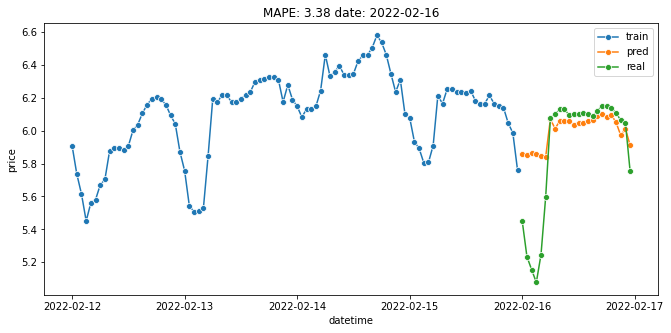

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


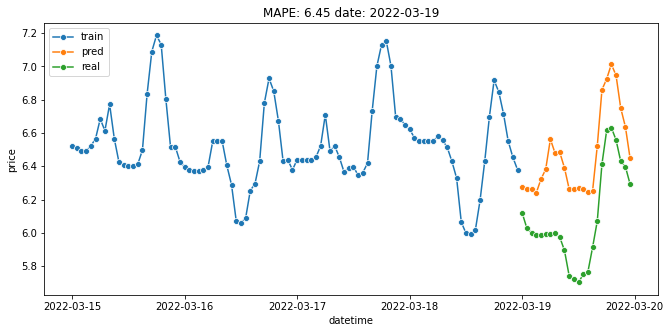

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


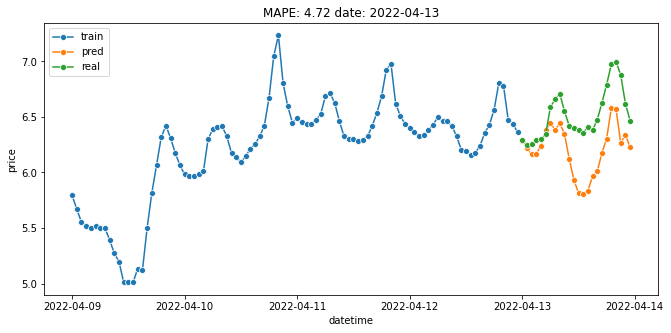

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


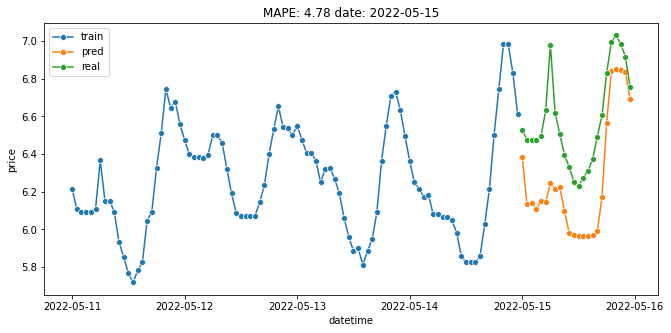

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


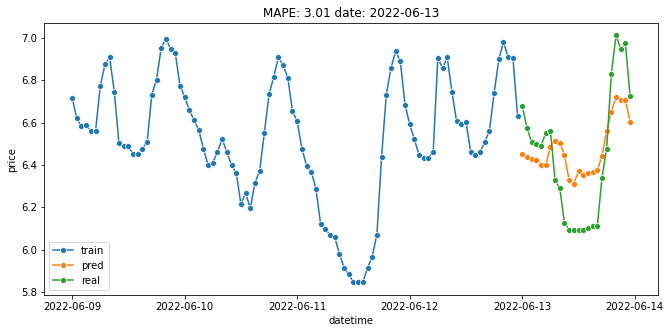

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


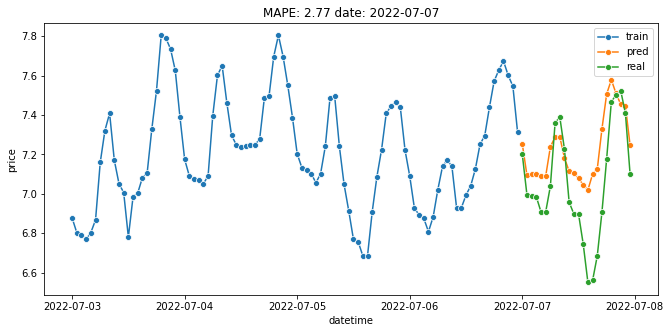

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


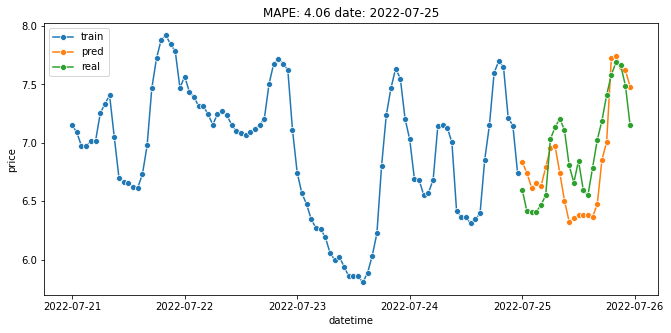

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


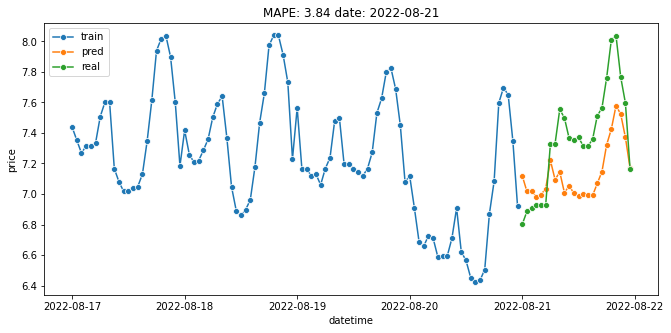

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


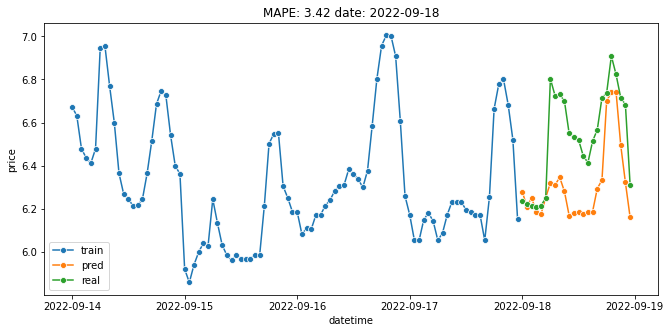

train:  (96, 974) test:  (24, 974)


<ipython-input-53-58ad540a4aa5>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])
<ipython-input-53-58ad540a4aa5>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred_third'] = tmp_test['pred']


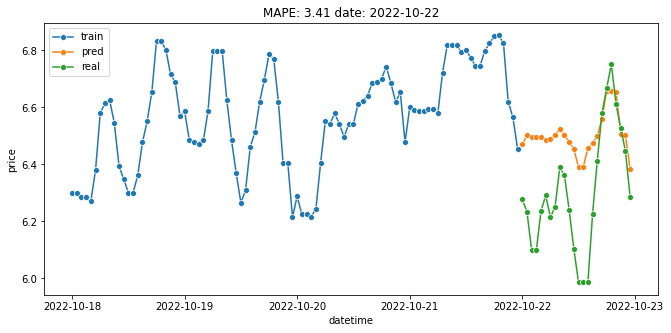

In [53]:
mapes = []
YCOL = 'price'
preds = pd.DataFrame()
for date in date_to_pred:
    tmp = df[df['data'] <= date].tail(24 * 5)

    tmp_train = tmp[tmp['is_valid'] == False]
    tmp_test =  tmp[tmp['is_valid'] == True]
    
#     tmp_train[YCOL] = np.log(tmp_train[YCOL])
    
    print("train: ", tmp_train.shape,"test: ", tmp_test.shape)
    
    model = lgb.LGBMRegressor(max_depth=5, n_estimators=200, random_state=0)
    model.fit(tmp_train[features], tmp_train[YCOL])
    
    
    tmp_test['pred'] = model.predict(tmp_test[features])
    #tmp_test['pred'] = tmp_test['price_shift24']
    plt.figure(figsize=(11, 5));
    sns.lineplot(x = 'datetime', y= 'price', data=tmp_train, marker = "o")
    sns.lineplot(x = 'datetime', y= 'pred', data=tmp_test, marker = "o")
    sns.lineplot(x = 'datetime', y= 'price', data=tmp_test, marker = "o")

#     tmp_test['pred'] = np.exp(tmp_test['pred'])
    
    tmp_test['pred_third'] = tmp_test['pred'] 
    preds = pd.concat([preds, tmp_test])
    mape_ = round(mape( tmp_test['price'], tmp_test['pred']),2)
    mapes.append(mape_)
    plt.title(f"MAPE: {mape_} date: {date}")
    plt.legend(['train','pred','real'])
    plt.show()

In [54]:
np.mean(mapes), np.median(mapes), np.std(mapes)

(3.119, 2.8899999999999997, 1.8660660045489639)

In [55]:
valid['pred_third'] = preds.reset_index()['pred_third']

In [56]:
min_results = {}
for data in valid['data'].unique():
    print("*******************")
    print(data)
    first = valid[valid['data'] == data]['pred_first']
    second = valid[valid['data'] == data]['pred_second']
    third = valid[valid['data'] == data]['pred_third'] 
    
    price = valid[valid['data'] == data]['price']
    min_results[data] = np.argmin( [mape(price, first), mape(price, second), mape(price, third)])
    
    print("first", mape(price, first))
    print("second", mape(price, second))
    print("third", mape(price, third))

*******************
2020-08-26
first 1.92
second 1.54
third 1.38
*******************
2020-10-01
first 0.9
second 2.85
third 1.6
*******************
2020-10-23
first 1.15
second 0.89
third 1.27
*******************
2020-11-24
first 1.09
second 3.13
third 8.54
*******************
2020-12-24
first 3.09
second 4.43
third 5.78
*******************
2021-01-13
first 2.07
second 2.1
third 3.4
*******************
2021-02-17
first 2.12
second 1.23
third 2.1
*******************
2021-03-08
first 2.51
second 1.58
third 0.92
*******************
2021-04-01
first 1.01
second 1.36
third 1.11
*******************
2021-05-02
first 0.99
second 1.74
third 1.01
*******************
2021-06-06
first 2.89
second 1.9
third 2.48
*******************
2021-06-28
first 1.14
second 0.75
third 0.59
*******************
2021-07-31
first 2.35
second 1.43
third 1.91
*******************
2021-08-21
first 1.52
second 1.81
third 2.37
*******************
2021-09-15
first 1.46
second 2.19
third 1.21
*******************
2021-10-07


In [57]:
date_to_pred = df[df['is_test']]['data'].drop_duplicates().tolist()

In [58]:
features = [f for f in feats if f != "date_"]

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


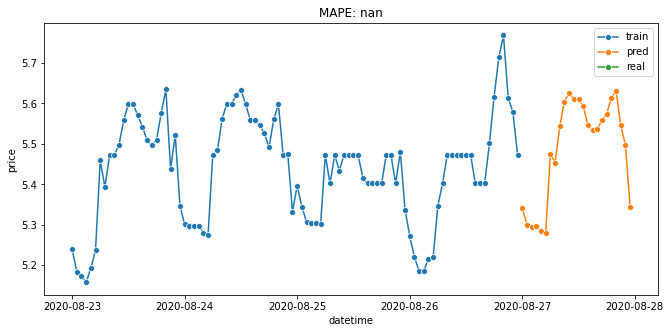

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


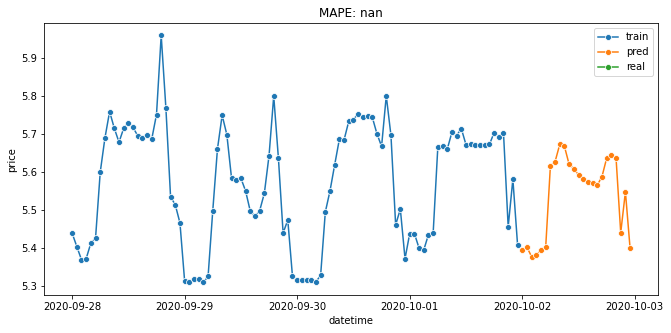

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


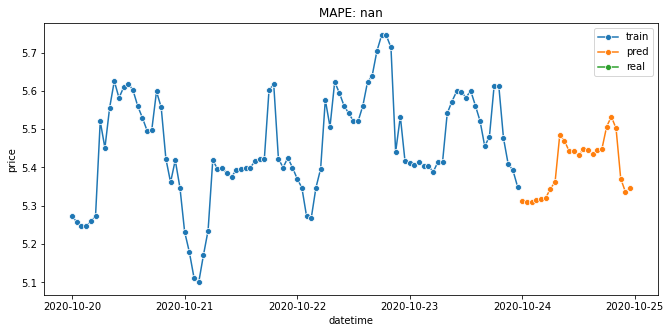

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


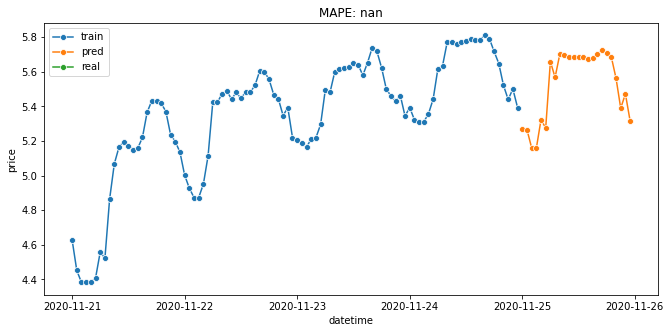

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


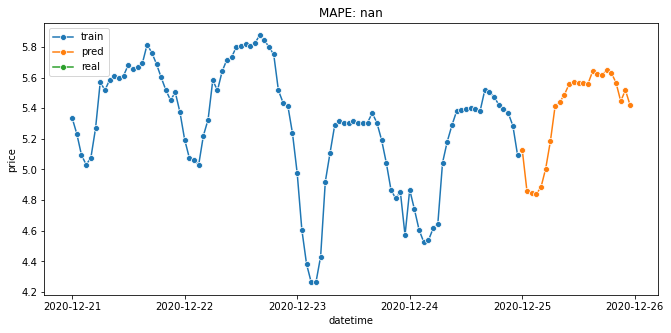

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


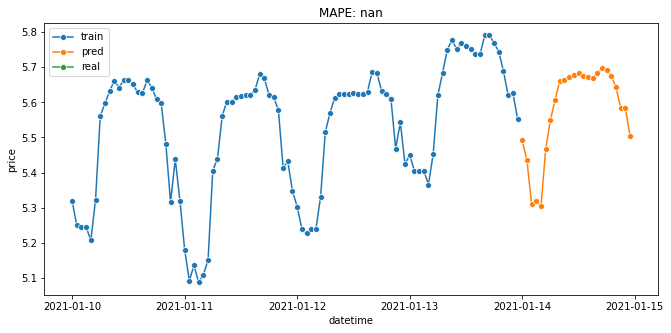

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


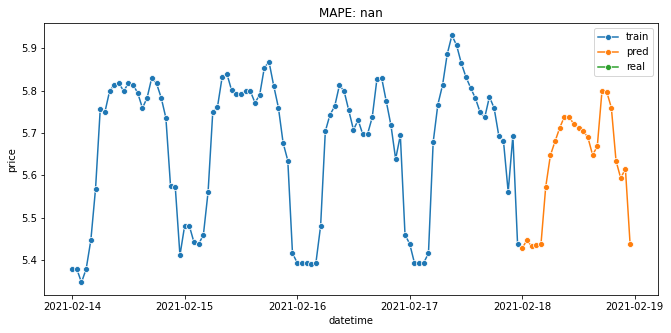

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


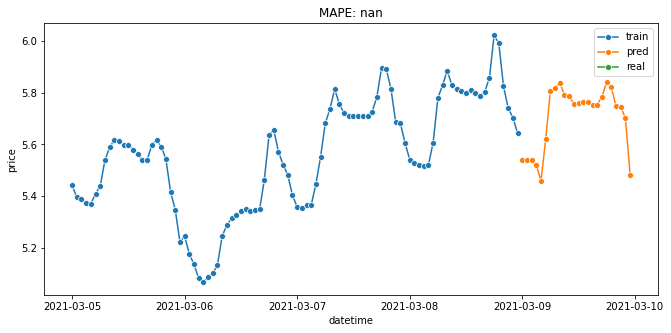

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


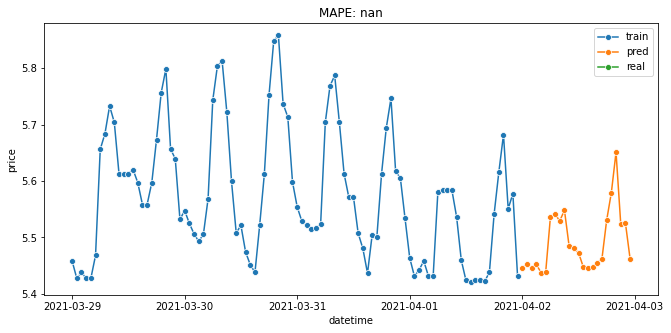

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


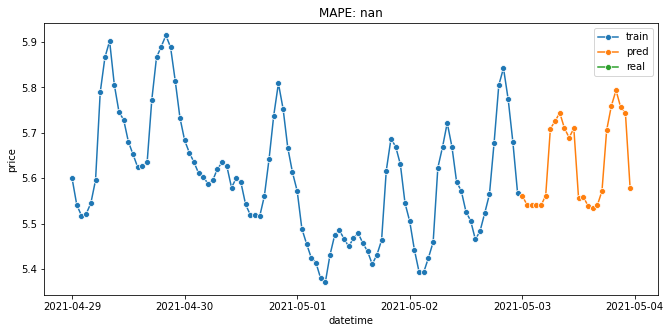

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


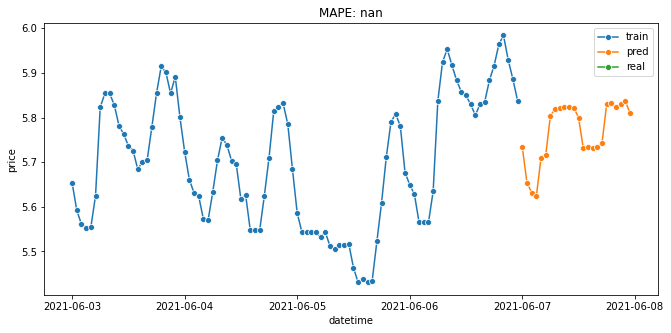

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


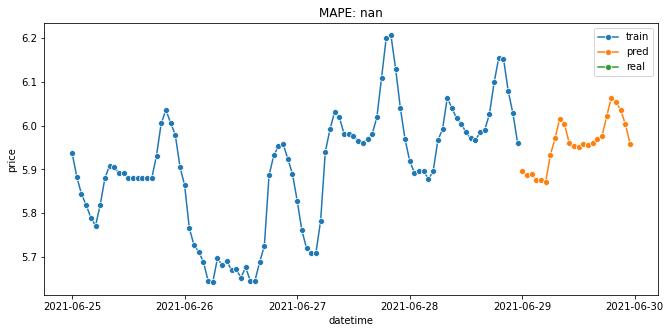

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


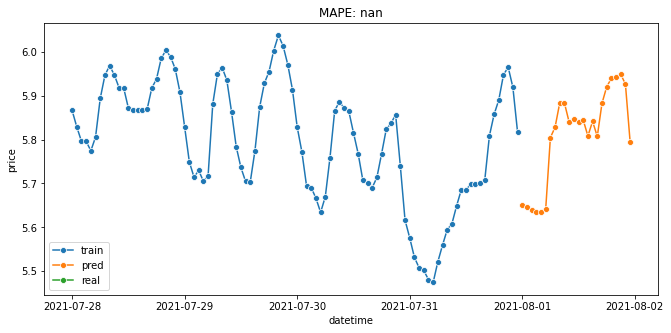

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


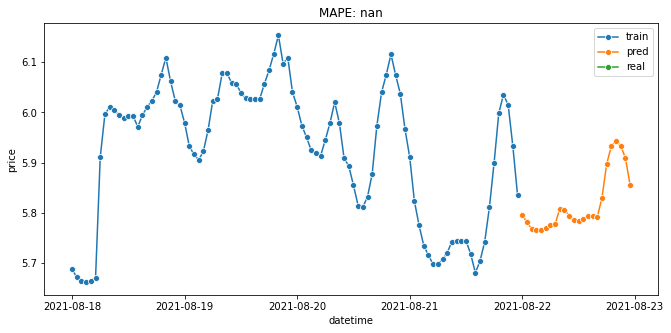

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


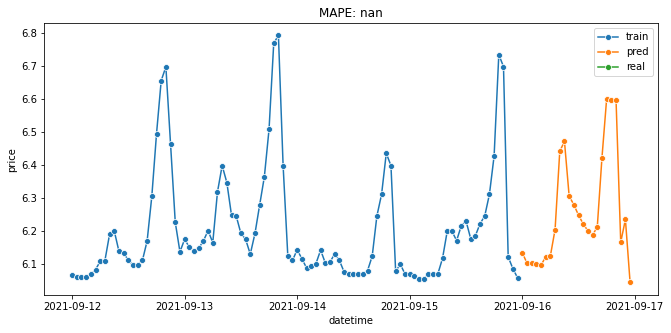

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


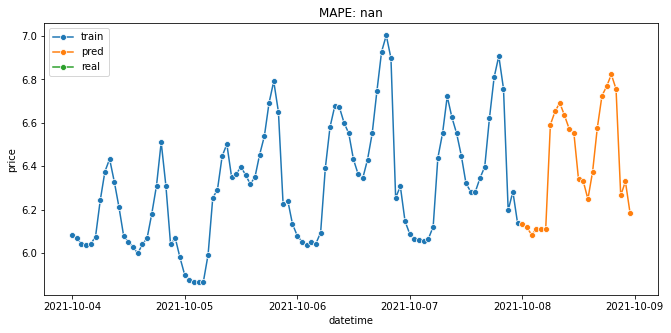

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


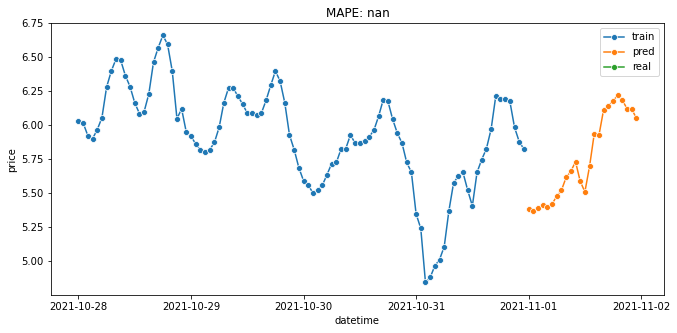

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


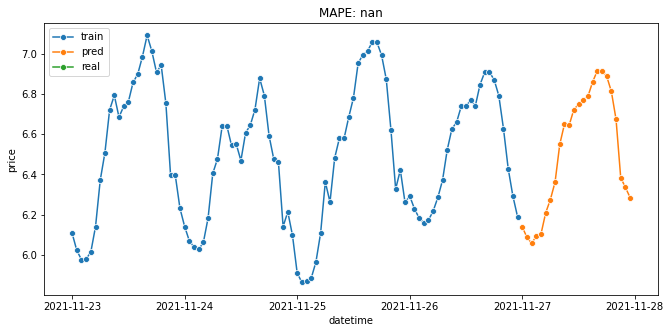

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


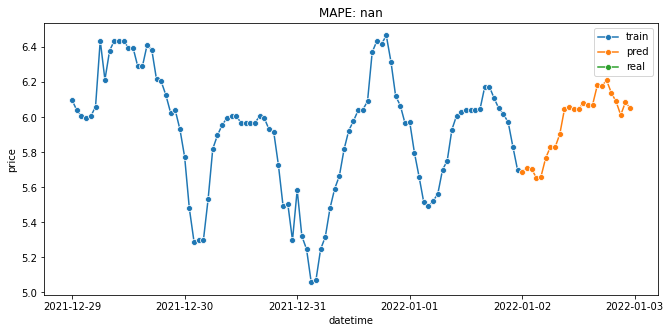

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


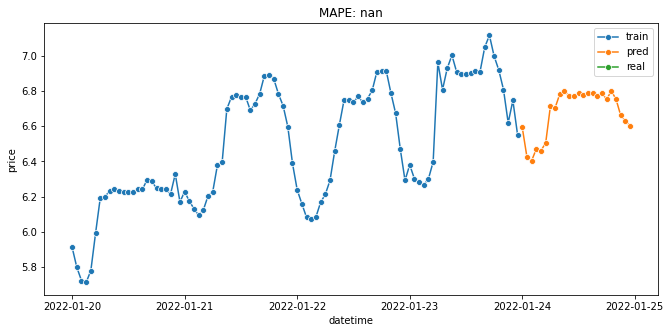

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


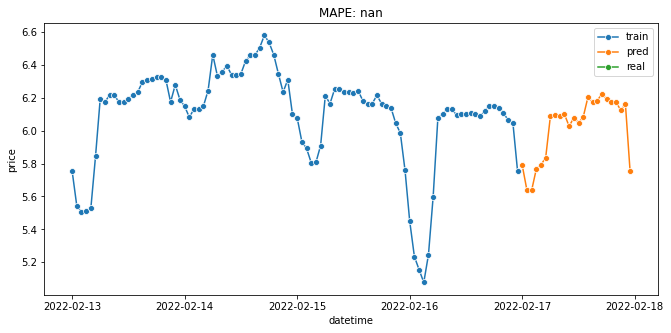

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


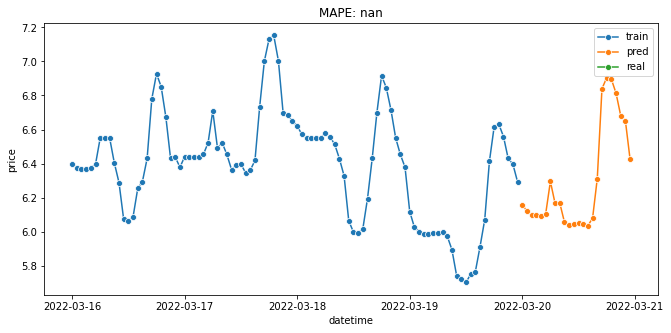

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


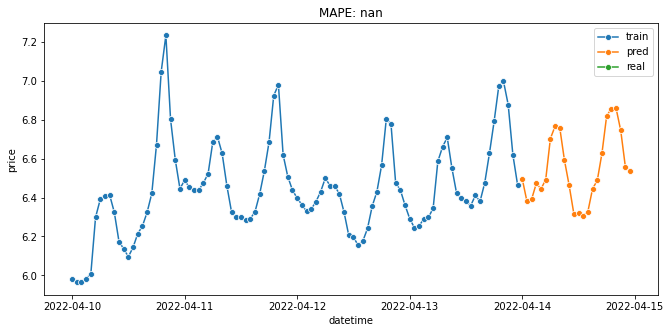

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


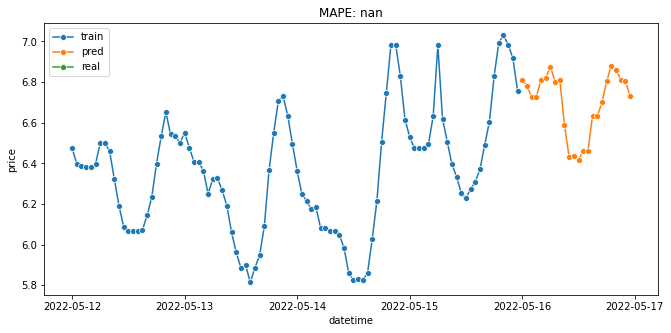

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


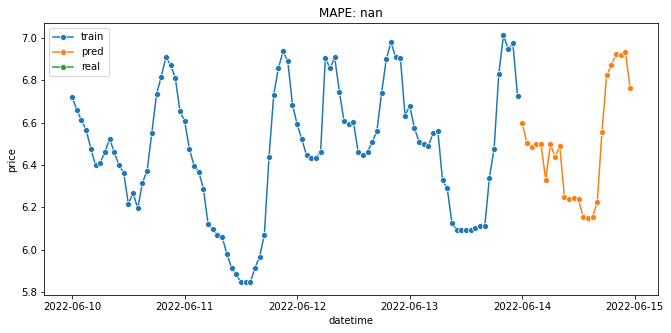

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


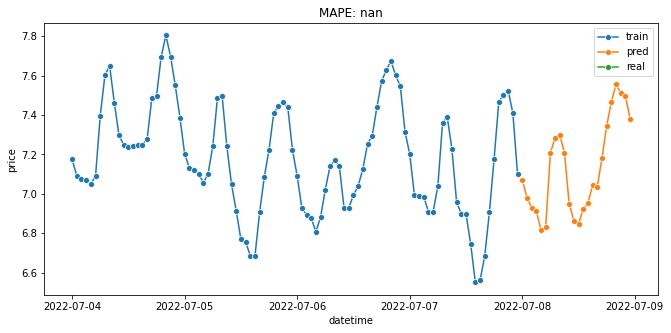

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


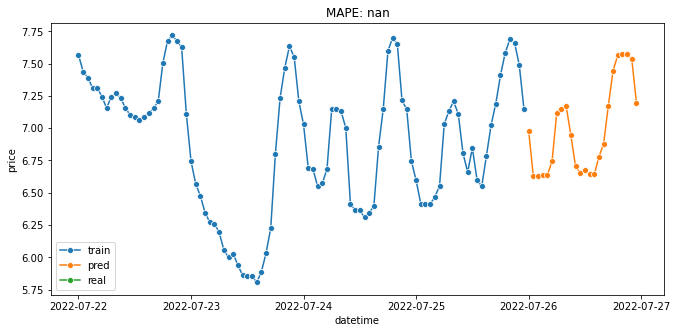

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


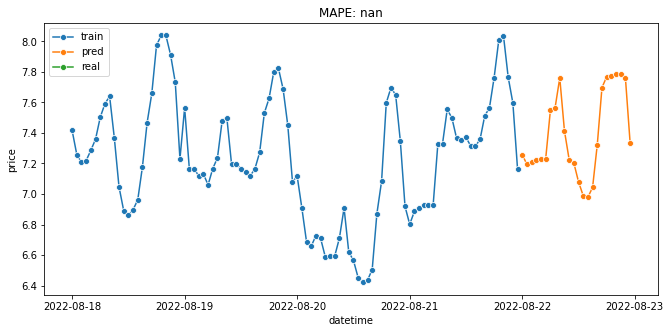

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


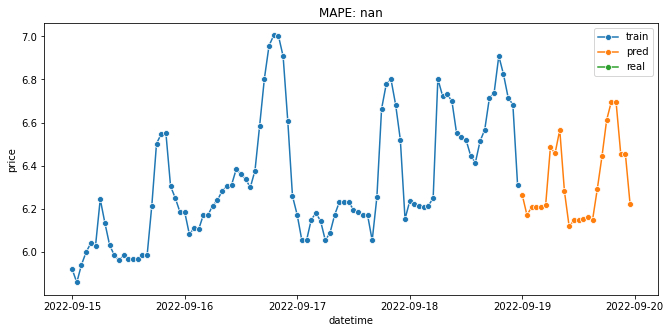

train:  (96, 974) test:  (24, 974)


<ipython-input-59-147216270db4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_test['pred'] = model.predict(tmp_test[features])


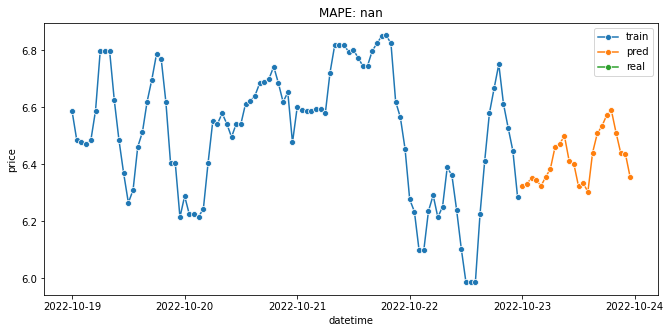

In [59]:
mapes = []
preds = pd.DataFrame()
for date in date_to_pred:
    tmp = df[df['data'] <= date].tail(24 * 5)

    tmp_train = tmp[tmp['is_test'] == False]
    tmp_test =  tmp[tmp['is_test'] == True]
    
#     tmp_train[YCOL] = np.log(tmp_train[YCOL])
    
    print("train: ", tmp_train.shape,"test: ", tmp_test.shape)
    
    model = lgb.LGBMRegressor(max_depth=5, n_estimators=200, random_state=0)
    model.fit(tmp_train[features], tmp_train[YCOL])
    
    
    tmp_test['pred'] = model.predict(tmp_test[features])
    #tmp_test['pred'] = tmp_test['price_shift24']
    plt.figure(figsize=(11, 5));
    sns.lineplot(x = 'datetime', y= 'price', data=tmp_train, marker = "o")
    sns.lineplot(x = 'datetime', y= 'pred', data=tmp_test, marker = "o")
    sns.lineplot(x = 'datetime', y= 'price', data=tmp_test, marker = "o")
#     tmp_test['pred'] = np.exp(tmp_test['pred'])
    
    
    preds = pd.concat([preds, tmp_test])
    mape_ = round(mape( tmp_test['price'], tmp_test['pred']),2)
    mapes.append(mape_)
    plt.title(f"MAPE: {mape_}")
    plt.legend(['train','pred','real'])
    plt.show()

In [60]:
df_test['pred_third'] = preds.reset_index()['pred'] 

In [61]:
test_pred = df_test[['datetime','data','is_test','pred_first','pred_second_all_data','pred_third']]

In [62]:
all_ = pd.concat([train[['datetime','price','is_test']], test_pred]).sort_values("datetime")

In [63]:
all_['data'] = all_['datetime'].dt.date

In [64]:
all_['data'] = pd.to_datetime(all_['data'])

<ipython-input-65-c4c83ab55897>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(11, 5));


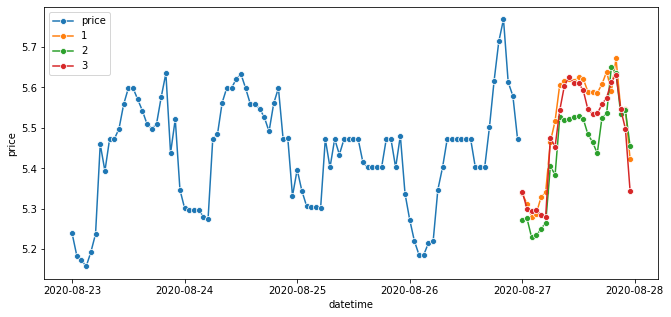

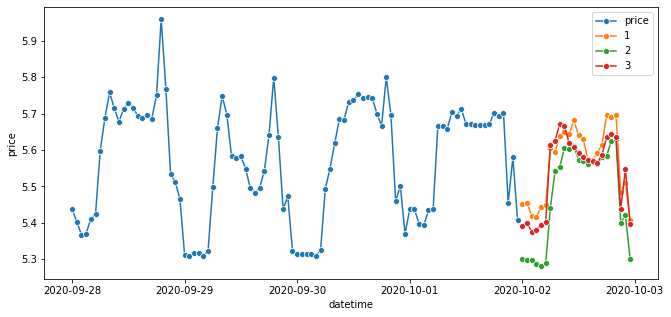

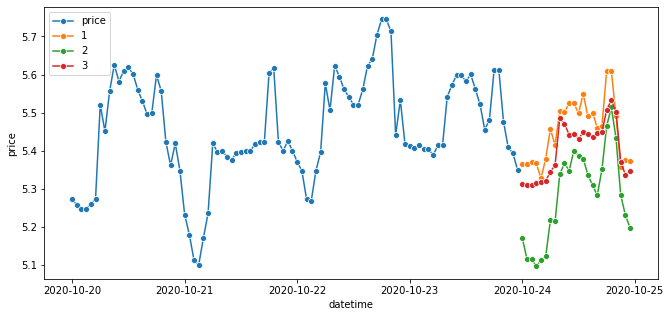

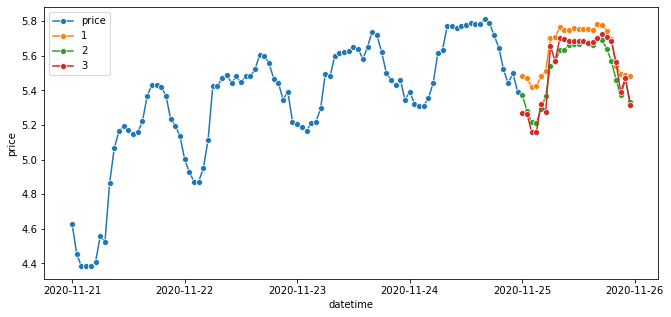

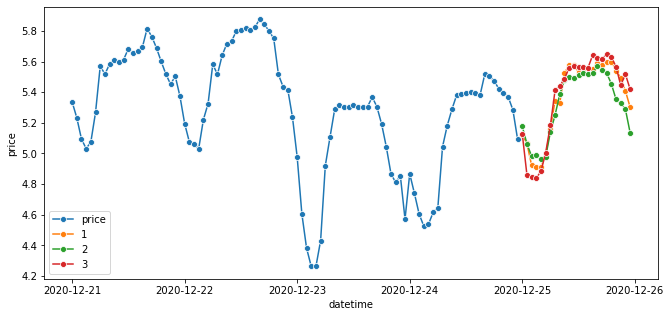

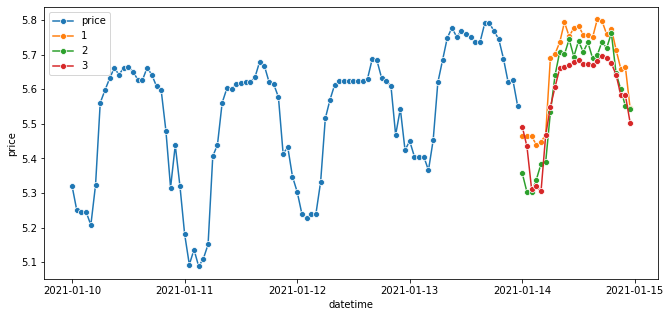

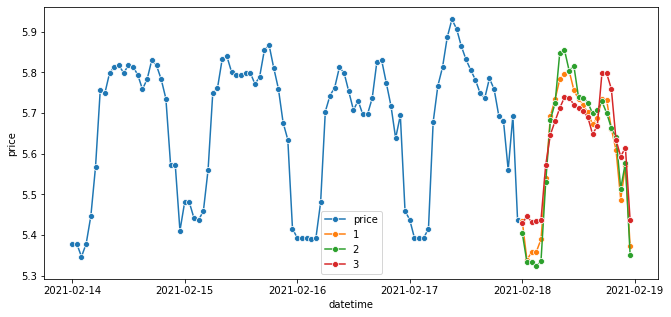

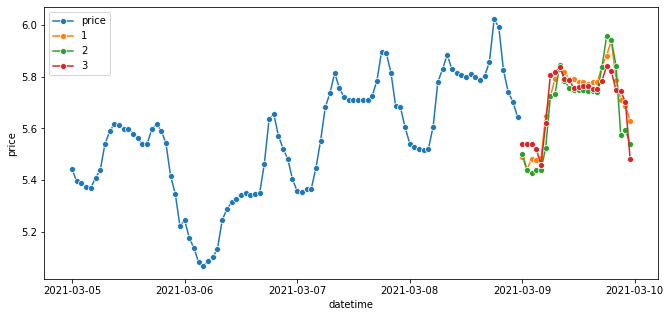

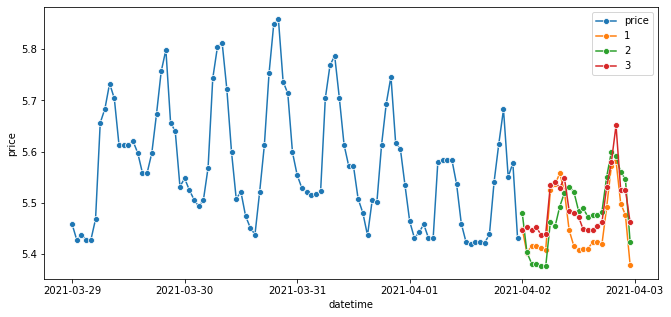

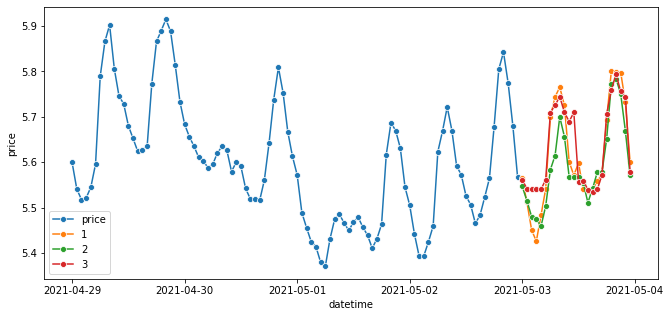

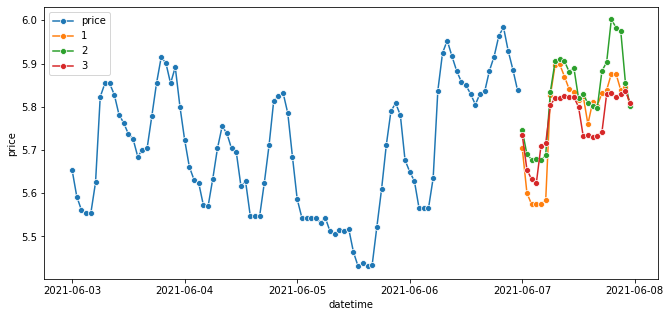

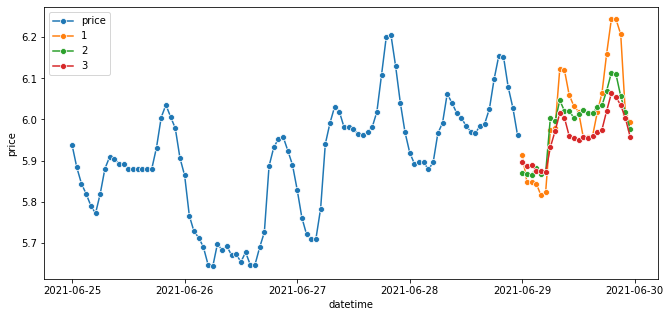

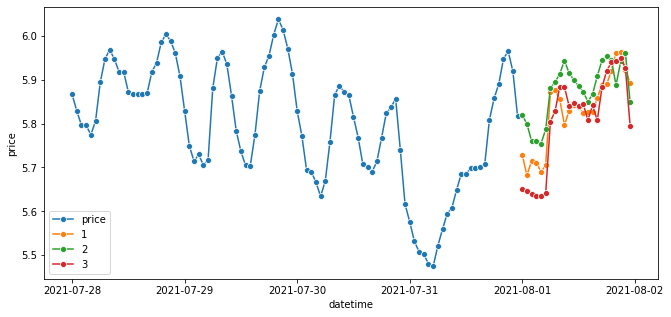

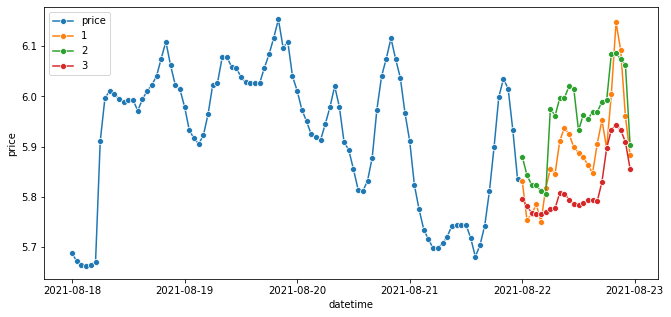

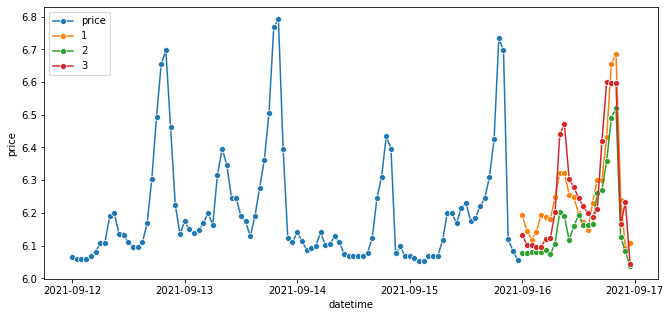

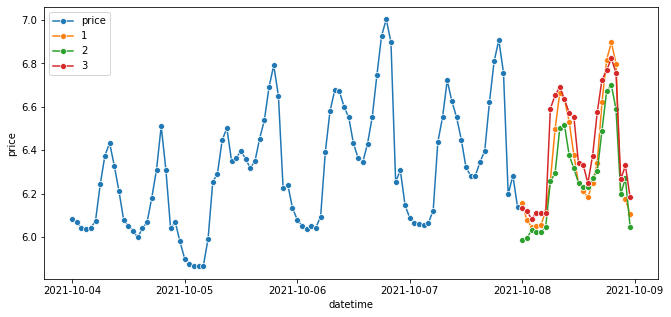

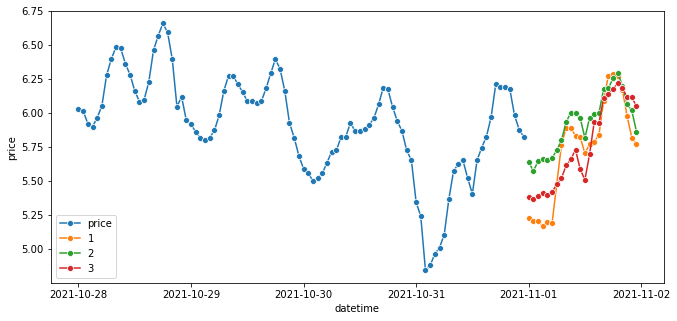

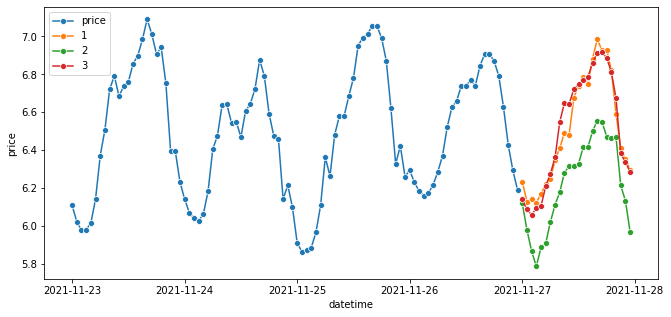

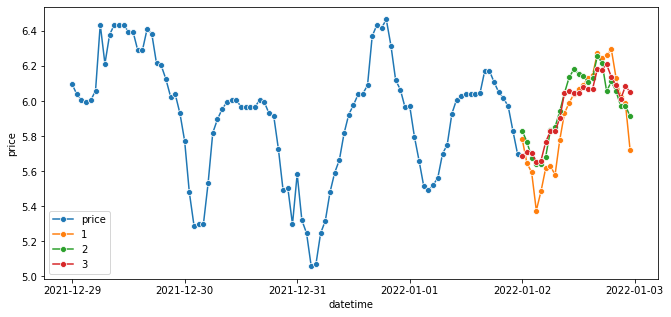

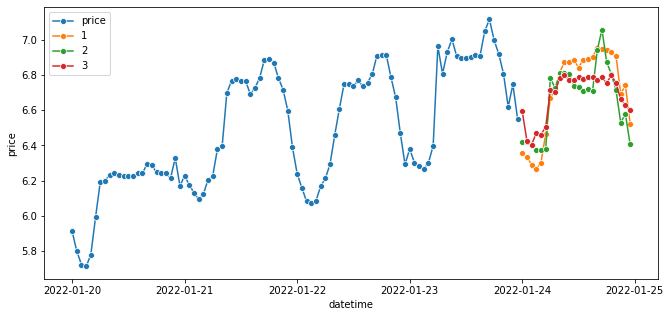

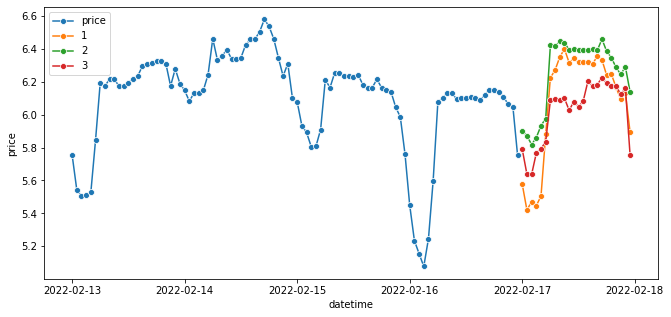

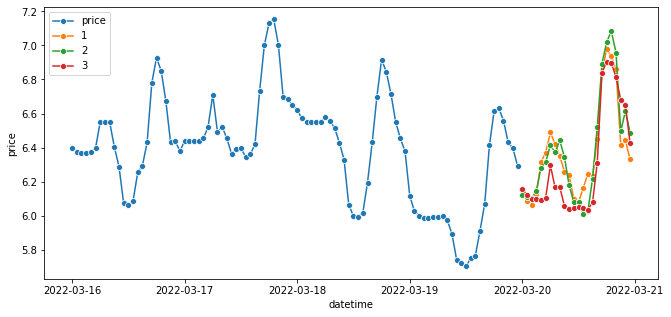

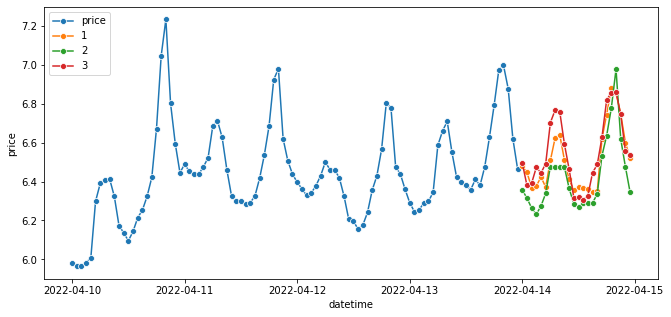

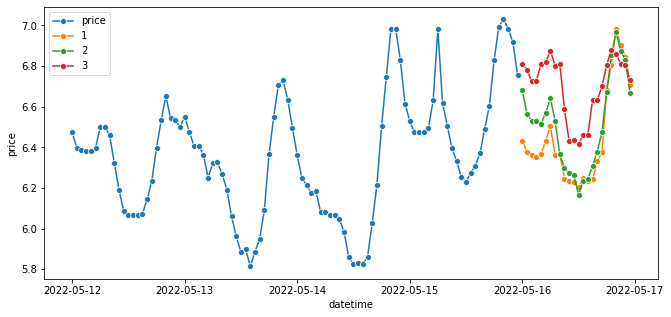

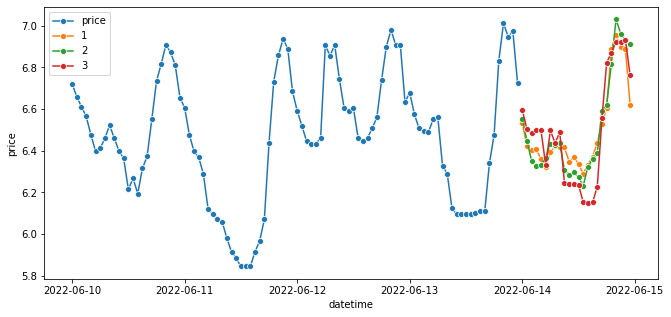

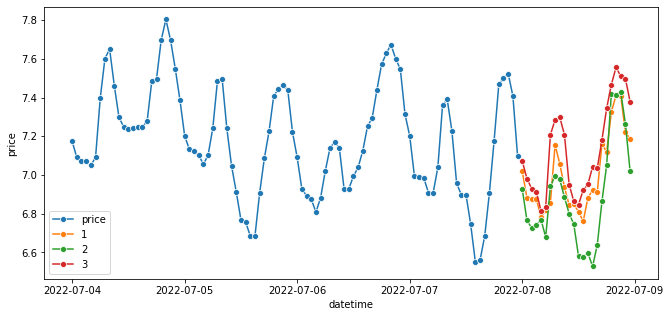

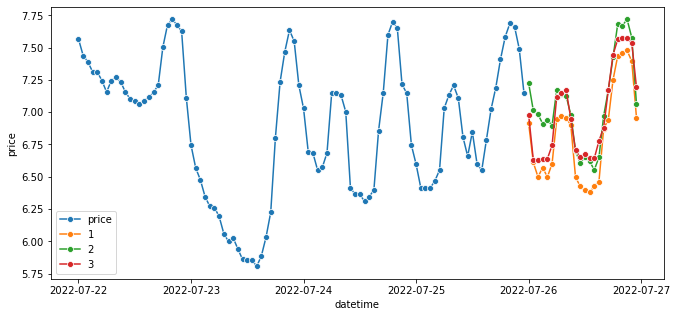

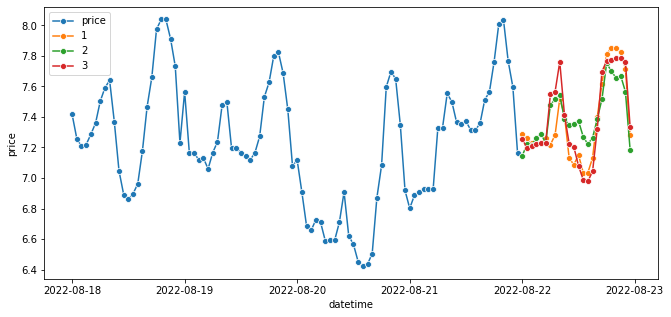

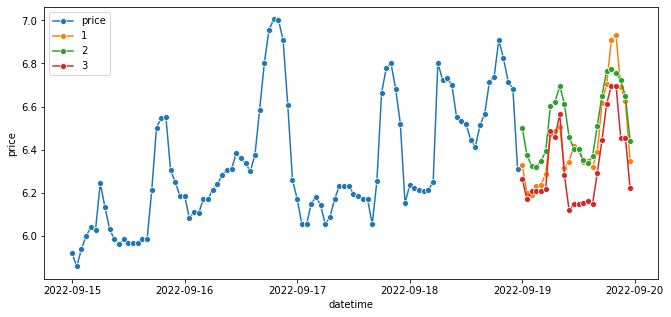

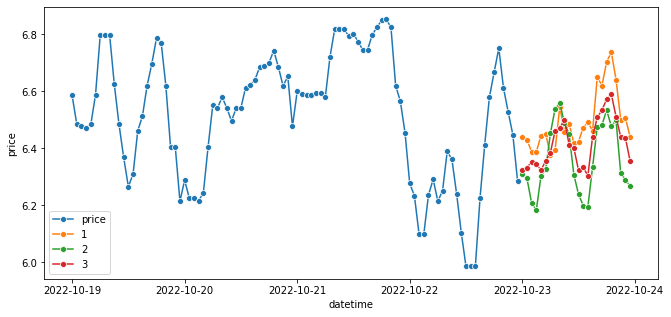

In [65]:
for date in date_to_pred:
    tmp = all_[all_['data'] <= date].tail(24 * 5)

    tmp_train = tmp[tmp['is_test'] == False]
    tmp_test =  tmp[tmp['is_test'] == True]
    
    plt.figure(figsize=(11, 5));
    sns.lineplot(x = 'datetime', y= 'price', data=tmp_train, marker = "o")
    sns.lineplot(x = 'datetime', y= 'pred_first', data=tmp_test, marker = "o")
    sns.lineplot(x = 'datetime', y= 'pred_second_all_data', data=tmp_test, marker = "o")
    sns.lineplot(x = 'datetime', y= 'pred_third', data=tmp_test, marker = "o")
    plt.legend(['price',"1","2","3"])

In [66]:
# test_pred = test_pred.set_index("datetime")

In [82]:
# test_pred['pred_mixed'] = np.exp(test_pred['pred_second_all_data']) * 0.33 + np.exp(test_pred['pred_second_all_data']) * 0.34 + np.exp(test_pred['pred_third']) * 0.33
test_pred['pred_mixed'] = np.exp(test_pred['pred_second_all_data']) * 0.6 + np.exp(test_pred['pred_second_all_data']) * 0.3 + np.exp(test_pred['pred_third']) * 0.1
# test_pred['pred_mixed'] = test_pred['pred_second_all_data'] * 0.7 + test_pred['pred_first'] * 0.2 + test_pred['pred_third'] * 0.1

In [83]:
which_pred_dict = {0: "pred_first",
                   1: "pred_second_all_data",
                   2: "pred_third"}

In [84]:
from collections import Counter

In [85]:
Counter(min_results.values())

Counter({2: 9, 0: 10, 1: 11})

In [71]:
pred = []
for data, which_pred in zip(test_pred['data'].unique(),min_results.values()):
    pred.extend(test_pred[test_pred['data'] == data][which_pred_dict[which_pred]].tolist())

In [72]:
test_pred['pred_which'] = np.exp(pred)

<ipython-input-72-f997ceba46ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_pred['pred_which'] = np.exp(pred)


In [73]:
test_pred = test_pred.reset_index()

In [74]:
test_pred.head()

index            datetime        data  is_test  pred_first  \
0      0 2020-08-27 00:00:00  2020-08-27     True    5.337874   
1      1 2020-08-27 01:00:00  2020-08-27     True    5.312542   
2      2 2020-08-27 02:00:00  2020-08-27     True    5.280026   
3      3 2020-08-27 03:00:00  2020-08-27     True    5.288410   
4      4 2020-08-27 04:00:00  2020-08-27     True    5.328705   

   pred_second_all_data  pred_third  pred_mixed  pred_which  
0              5.272340    5.342164  199.522092  208.964423  
1              5.276726    5.300728  197.297079  200.482645  
2              5.229278    5.294675  190.820945  199.272870  
3              5.234313    5.296031  191.541405  199.543316  
4              5.250214    5.285937  192.894577  197.539117

In [86]:
col = "pred_mixed"
test_pred["price"] = test_pred[col]
test_pred[["datetime","price"]].to_csv(f"../output/{col}_final.csv",index = False)